# Query Log Analysis

The goal of this notebook is to serve as a way to quickly analyze a query log, based on the following aspects:

- Query-level
- Topic-level
- Session-level
- Term-level
- Entity-level

Our main focus is on understanding how people search, in order to improve entity-oriented search, thus we will tackle these aspects always around the entities.

**Requirements:**

- pandas
- numpy
- sklearn
- igraph
- progressbar2

**Suggestion:**

For better exploration and readability of this notebook install the extensions:
  
  - collapsible_headings
    ```sh
    pip install jupyter_contrib_nbextensions
    jupyter nbextension enable collapsible_headings/main
    ```
  - toc
    ```sh
    jupyter nbextension install --user https://rawgithub.com/minrk/ipython_extensions/master/nbextensions/toc.js
    jupyter nbextension enable toc
    ```

## Dependencies

In [1]:
import os
import re
import codecs
import collections
import warnings
import progressbar
import gzip
import datetime
import hashlib
import itertools

import urllib.parse

import igraph

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn import naive_bayes, linear_model

from joblib import Memory

%load_ext autotime

## Settings

In [2]:
DEFAULT_FIGSIZE = [15, 3]
DEFAULT_MAX_ROWS = 8

plt.rc('figure', figsize=DEFAULT_FIGSIZE)
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', DEFAULT_MAX_ROWS)

memory = Memory('output/cache', verbose=0)

# Query log analysis notebook settings
lang = 'en'

time: 5.9 ms


## Utilities

In [3]:
def flatten(l, remove_none=True):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        elif not el is None:
            yield el

list(flatten([1,2,[4,5], [[6,7,None]], None]))

[1, 2, 4, 5, 6, 7]

time: 17.4 ms


In [4]:
def mk_outdir(output_dir):
    path = os.path.join("output", output_dir)
    os.makedirs(path, exist_ok=True)
    return path

time: 6.97 ms


# Structure of the data directory

Before loading your data, please obtain the datasets from the corresponding sources, as listed above. The `data` directory tree should look something like this:

```bash
data/
├── ant-search-log
│   ├── ant-search_interaction_log-20190731T1621.csv.gz
│   └── ant-search_query_log-20190731T1621.csv.gz
├── AOL-user-ct-collection
│   ├── user-ct-test-collection-01.txt.gz
│   ├── user-ct-test-collection-02.txt.gz
│   ├── user-ct-test-collection-03.txt.gz
│   ├── user-ct-test-collection-04.txt.gz
│   ├── user-ct-test-collection-05.txt.gz
│   ├── user-ct-test-collection-06.txt.gz
│   ├── user-ct-test-collection-07.txt.gz
│   ├── user-ct-test-collection-08.txt.gz
│   ├── user-ct-test-collection-09.txt.gz
│   ├── user-ct-test-collection-10.txt.gz
│   └── U500k_README.txt
├── bbc
│   ├── business
│   │   ├── 001.txt
│   │   ├── 002.txt
│   │   ├── 003.txt
│   │   └── ...
│   ├── entertainment
│   │   ├── 001.txt
│   │   ├── 002.txt
│   │   ├── 003.txt
│   │   └── ...
│   ├── politics
│   │   ├── 001.txt
│   │   ├── 002.txt
│   │   ├── 003.txt
│   │   └── ...
│   ├── sport
│   │   ├── 001.txt
│   │   ├── 002.txt
│   │   ├── 003.txt
│   │   └── ...
│   ├── tech
│   │   ├── 001.txt
│   │   ├── 002.txt
│   │   ├── 003.txt
│   │   └── ...
│   └── README.TXT
├── entity_lists
│   ├── en_dbpedia_organization.txt
│   ├── en_dbpedia_person.txt
│   ├── en_dbpedia_place.txt
│   ├── pt_dbpedia_organization.txt
│   ├── pt_dbpedia_person.txt
│   └── pt_dbpedia_place.txt
├── episa -> /media/hdd0/datasets/episa
│   ├── Logs_Web1
│   │   ├── u_ex190601.log
│   │   ├── u_ex190602.log
│   │   ├── u_ex190603.log
│   │   └── ...
│   └── Logs_Web2
│       ├── u_ex19063022.log
│       ├── u_ex19063023.log
│       ├── u_ex19070100.log
│       └── ...
├── psql_stopwords
│   ├── english.stop
│   └── portuguese.stop
├── simplewiki_link_graph-201812.gml
└── webis-smc-12.txt

```

# Datasets

While we take advantage of the Wikipedia query log for this analysis, we use an intermediate structure, so that you can convert your own query log into our format and analyze it. We begin by applying the analysis to the webis-smc-12 dataset, only then adapting the notebook for the Wikipedia query log.

The loader functions will be responsible for loading query log datasets and converting them into a Pandas DataFrame with the following valid columns (only columns with data are required):

- user_id
- query
- timestamp
- click_rank
- click_title
- click_url
- click_timestamp

## webis-smc-12

The Webis Search Mission Corpus 2012 (Webis-SMC-12) contains 8840 entries for 127 users. It is built from a subset of the AOL query log. Each entry includes user ID, query, timestamp, rank and domain URL for clicked results, a mission ID and a comment. Each user is preceded by a line of dashes in the text file. More information is available at: https://webis.de/data/webis-smc-12.html

In [5]:
def load_webis_smc_12(path):
    """Load webis-smc-12.txt file into the notebook query log analysis format."""
   
    def date_parser(date_str):
        if type(date_str) is float and np.isnan(date_str):
            return np.nan
        else:
            return pd.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            
    def get_sep_row_idx():
        sep_row_idx = []
        
        with open(path, "r") as fp:
            line_number = 0
            for line in fp:
                if line.startswith("---"):
                    sep_row_idx.append(line_number)
                line_number += 1
        
        return sep_row_idx
    
    df = pd.read_csv(
        'data/webis-smc-12.txt',
        sep='\t',
        lineterminator='\n',
        skiprows=get_sep_row_idx(),
        error_bad_lines=False,
        warn_bad_lines=False,
        parse_dates=['TimeStamp'],
        date_parser=date_parser)

    df.drop(columns=['MissionID', 'Comment'], inplace=True)
    
    df.rename(
        columns={
            'UserID': 'user_id',
            'Query': 'query',
            'TimeStamp': 'timestamp',
            'ClickRank': 'click_rank',
            'ClickDomain': 'click_url'
        },
        inplace=True)
    
    df.click_rank = df.click_rank.astype(pd.Int64Dtype())
    
    return df, mk_outdir("webis-smc-12")

time: 38.3 ms


## AOL query log

AOL query log contains 36 million entries from over half a million users, covering a period of three months, from March to May 2006. The dataset itself contains 10 text files, each containing a user ID, the query, a timestamp and, if present, the rank and URL of a clicked result. While this has become a controversial dataset, because of privacy issues, it remains one of the largest available datasets for analyzing user behavior.

In [6]:
def load_aol_query_log(path):
    data = pd.DataFrame(columns=['user_id', 'query', 'timestamp', 'click_rank', 'click_url'])
    
    for filename in sorted(os.listdir(path)):
        if filename.startswith('user-ct-test-collection-'):
            df = pd.read_csv(
                    os.path.join(path, filename),
                    sep='\t',
                    parse_dates=['QueryTime'],
                    low_memory=False,
                    compression='gzip'
                ).rename(columns={
                    'AnonID': 'user_id',
                    'Query': 'query',
                    'QueryTime': 'timestamp',
                    'ItemRank': 'click_rank',
                    'ClickURL': 'click_url'
                })
            data = data.append(df, ignore_index=True)
    
    data['user_id'] = pd.to_numeric(data['user_id'], errors='coerce')
    data['click_rank'] = pd.to_numeric(data['click_rank'], errors='coerce')

    return data, mk_outdir("aol-query-log")

time: 21.2 ms


## ANT search log

The [ANT](https://ant.fe.up.pt) search log contains 45,059 search queries, mostly in Portuguese, for 9,403 users, as identified by a hash of their client IP, user agent and display resolution. It also separately provides interaction data about result clicks, containing 27480 records for 7642 users, that should match the users in the query log. The ANT search query log provides the query category according to the classification by [Pound et al. (2010)](https://doi.org/10.1145/1772690.1772769), as computed by [ANT's query understanding module](https://doi.org/10.1007/978-3-319-44564-9_17). Please notice that there is an error associated discovering a query's category, as this was not manually annotated.

In [7]:
def load_ant_search_log(path):
    q_paths = [fn for fn in os.listdir(path) if fn.startswith('ant-search_query_log-')]
    i_paths = [fn for fn in os.listdir(path) if fn.startswith('ant-search_interaction_log-')]
    
    assert len(q_paths) > 0 and len(i_paths) > 0, \
        'Both an "ant-search_query_log-*.csv.gz" and an "ant-search_interaction_log-*.csv.gz" must exist'
    
    q_path = os.path.join(path, sorted(q_paths)[-1])
    i_path = os.path.join(path, sorted(i_paths)[-1])
    
    queries = pd.read_csv(q_path, sep='\t', parse_dates=['timestamp']) \
        [['user_id', 'query', 'timestamp']] \
        .dropna(subset=['user_id', 'query'])
    
    queries['click_rank'] = np.nan
    queries['click_url'] = np.nan
    queries['click_timestamp'] = np.nan
    queries['type'] = 'query'
    
    queries = queries[['user_id', 'query', 'timestamp', 'click_rank', 'click_url', 'click_timestamp', 'type']]
    
    inter = pd.read_csv(i_path, sep='\t', parse_dates=['timestamp']) \
        [['user_id', 'query', 'timestamp', 'clicked_rank', 'clicked_url']] \
        .dropna(subset=['user_id', 'query']) \
        .rename(columns={
            'clicked_rank': 'click_rank',
            'clicked_url': 'click_url'
        })
    
    inter['click_timestamp'] = inter['timestamp']
    inter['type'] = 'click'
    
    inter = inter[['user_id', 'query', 'timestamp', 'click_rank', 'click_url', 'click_timestamp', 'type']]
    
    df = pd.concat([queries, inter]) \
        .sort_values(by='timestamp') \
        .reset_index()
            
    return df, mk_outdir("ant-search-log")

time: 106 ms


## EPISA DigitArq access log

The EPISA DigitArq access log contains 110,447,807 entries. We filtered 111,819 requests to `/results` and 309,517 requests to `/details`, corresponding to result clicks.

You can generate the required `results.log` and `details.log` from the original access log files by running the following commands, after decompressing both 7-zip files:

```
(cd Logs_Web1 && awk 'BEGIN { FS=" " } $5 ~ /^\/results.*/ { print $0 }' *) | sudo tee results.log
(cd Logs_Web2 && awk 'BEGIN { FS=" " } $5 ~ /^\/results.*/ { print $0 }' *) | sudo tee -a results.log

(cd Logs_Web1 && awk 'BEGIN { FS=" " } $5 ~ /^\/details.*/ { print $0 }' *) | sudo tee details.log
(cd Logs_Web2 && awk 'BEGIN { FS=" " } $5 ~ /^\/details.*/ { print $0 }' *) | sudo tee -a details.log
```

In [8]:
# FIXME This does not yet work, as there is no relation between queries and clicked results.
def load_episa_search_log(*paths):
    base_uri = 'https://digitarq.arquivos.pt'
    bots_re = re.compile(r'.*(nagios|bot).*', re.IGNORECASE)
    query_re = re.compile(r"""^/results?.*t=([^&]+)""")

    def log_entry_generator():
        for path in paths:
            with codecs.open(path, 'r', 'utf-8') as fp:
                for line in fp:
                    yield line.strip()

    def unicode_unquote(text):
        def unicode_unquoter(match):
            return chr(int(match.group(1),16))
        return re.sub(r'%u([0-9a-fA-F]{4})', unicode_unquoter, text)

    def build_url(uri_stem, uri_query):
        if uri_query is not None and uri_query != '-':
            url = '%s?%s' % (uri_stem, uri_query)
        else:
            url = uri_stem
            
        return unicode_unquote(urllib.parse.unquote(url))
                    
    def uri_to_search_query(uri_stem, uri_query):
        url = build_url(uri_stem, uri_query)
        query_m = query_re.match(url)
        if query_m:
            return query_m.group(1)

    data = {
        'user_id': [],
        'query': [],
        'timestamp': [],
        'click_rank': [],
        'click_url': [],
        'referer': []
    }
    
    for line in log_entry_generator():
        if line.startswith('#'):
            continue
        
        date, time, _, _, uri_stem, uri_query, _, _, client_ip, client_ua, referer, _  = line.split(maxsplit=11)
        
        if bots_re.match(client_ua):
            #warnings.warn('Skipping bot: %s' % client_ua)
            continue
            
        if uri_stem.startswith('/details') and not referer.startswith('https://digitarq.arquivos.pt/results'):
            #warnings.warn('Skipping details without referer: %s' % uri_stem)
            continue
            
        user_id = hashlib.md5(('%s %s' % (client_ip, client_ua)).encode()).hexdigest()
        
        query = uri_to_search_query(uri_stem, uri_query)
        
        timestamp = pd.to_datetime('%s %s' % (date, time))
        
        click_rank = None
        
        if uri_stem.startswith('/details'):
            click_url = urllib.parse.urljoin(base_uri, build_url(uri_stem, uri_query))
        else:
            click_url = None
        
        referer = None if referer == '-' else referer
        
        if query is None and click_url is None:
            continue
        
        data['user_id'].append(user_id)
        data['query'].append(query)
        data['timestamp'].append(timestamp)
        data['click_rank'].append(None)
        data['click_url'].append(click_url)       
        data['referer'].append(referer)
        
    df = pd.DataFrame(data) \
        .sort_values(by=['user_id', 'timestamp'])
    
    return df, mk_outdir("episa-digitarq-access-log")

time: 222 ms


# Data loading

Select one of the available dataset loading functions to begin the analysis:

- load_webis_smc_12
- load_aol_query_log
- load_ant_search_log
- load_episa_search_log

In [9]:
qlog, output_dir = load_webis_smc_12('data/webis-smc-12.txt')
#qlog, output_dir = load_aol_query_log('data/AOL-user-ct-collection')
#qlog, output_dir = load_ant_search_log('data/ant-search-log')
#qlog, output_dir = load_episa_search_log('data/episa/results.log', 'data/episa/details.log')

display(output_dir)
display(qlog)

'output/webis-smc-12'

,user_id,query,timestamp,click_rank,click_url
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org
...,...,...,...,...,...
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN
8835,24797984,fw signs from god,2006-05-29 15:44:27,NaN,NaN
8836,24797984,fw signs from god,2006-05-29 15:44:31,NaN,NaN
8837,24797984,fw signs from god,2006-05-29 15:44:38,NaN,NaN


time: 198 ms


# Query-level analysis

- Number of queries / interactions
- Number of distinct queries
- Distribution of number of queries / interactions per user
- Distribution of queries / interactions over time
  - Per day
  - For 24h cycles
  - For weekday cycles
  - For monthly cycles

## Total number of queries and distinct queries

In [10]:
qlevel_stats = pd.DataFrame(
    [qlog.shape[0], len(qlog['query'].unique())],
    columns=['value'],
    index=['num_queries', 'num_distinct_queries'])
qlevel_stats

,value
num_queries,8838
num_distinct_queries,3736


time: 14.6 ms


## Distribution of number of queries per user

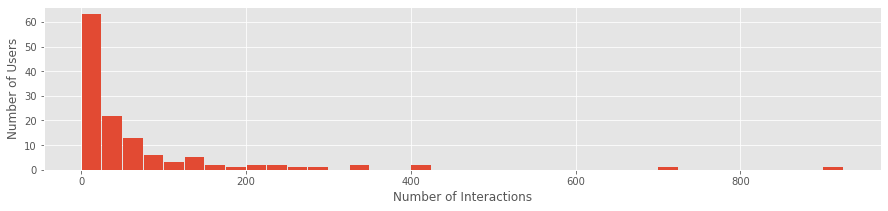

time: 298 ms


In [11]:
queries_per_user = qlog[['user_id', 'query']] \
    .groupby(['user_id']) \
    .count()

d_max = queries_per_user['query'].max()
bin_width = 25

queries_per_user \
    .plot(kind='hist', bins=range(0, d_max+bin_width, bin_width), logy=False, rwidth=.95, legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.show()

## Distribution of queries over time

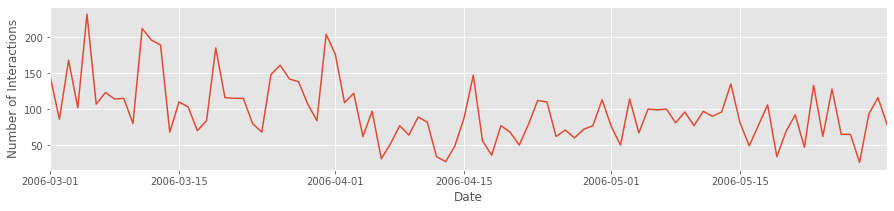

time: 248 ms


In [12]:
qlog['date'] = qlog['timestamp'].map(lambda t: t.date())

qlog \
    .groupby('date') \
    .size() \
    .plot()
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

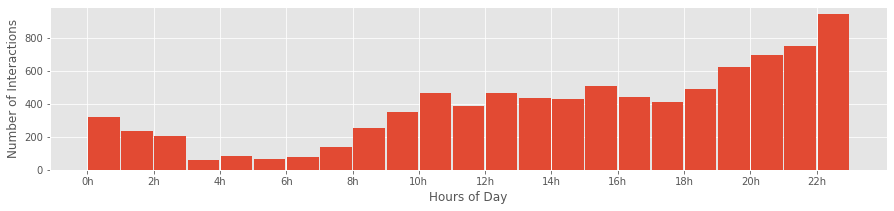

time: 325 ms


In [13]:
qlog['hour'] = qlog['timestamp'].map(lambda t: t.hour)
qlog['hour'] \
    .plot(kind='hist', bins=23, rwidth=.95)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)])
plt.xlabel('Hours of Day')
plt.ylabel('Number of Interactions')
plt.show()

### Per weekday cycles

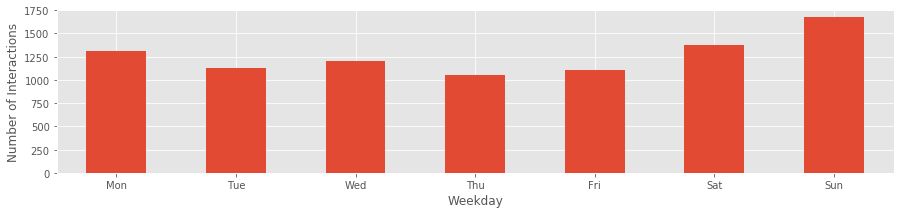

time: 253 ms


In [14]:
weekdays=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
qlog['weekday'] = qlog['timestamp'].map(lambda t: t.weekday())

qlog \
    .groupby(['weekday']) \
    .size() \
    .plot(kind='bar')

plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.xlabel('Weekday')
plt.ylabel('Number of Interactions')
plt.show()

### Per monthly cycles

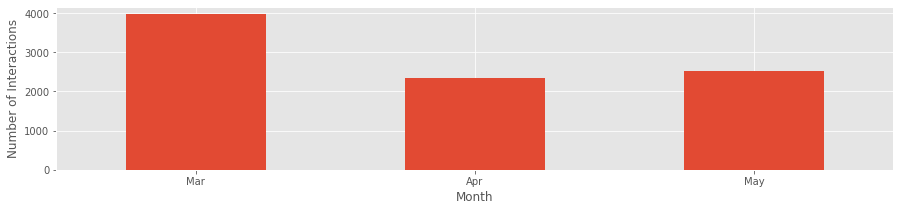

time: 180 ms


In [15]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
qlog['month'] = qlog['timestamp'].map(lambda t: t.month)

queries_per_month = qlog \
    .groupby(['month']) \
    .size() \

queries_per_month \
    .plot(kind='bar')

plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.xlabel('Month')
plt.ylabel('Number of Interactions')
plt.show()

# Topic-level analysis

We will look at the categories (more general) and topics (more specific) of the query log, analyzing:

- Distribution of query categories
- Distribution of query topics


- Distribution of query categories over time:
  - Per 24h cycles
  - Per weekday cycles
  - Per monthly cycles


- Distribution of query topics over time:
  - Per 24h cycles
  - Per weekday cycles
  - Per monthly cycles

## Category detection

We train a classifier based on the [BBC dataset](http://mlg.ucd.ie/datasets/bbc.html), with 2225 documents and 5 categories:

- business
- entertainment
- politics
- sport
- tech

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_paths_per_class(bbc_base_dir):
    """Get dictionary of paths per class for BBC dataset."""
    
    bbc = {}
    
    for file in os.listdir(bbc_base_dir):
        class_path = os.path.join(bbc_base_dir, file)
        
        if os.path.isdir(class_path):
            label = file
            bbc[label] = []
            
            for file in os.listdir(class_path):
                doc_path = os.path.join(class_path, file)
                if os.path.isfile(doc_path):
                    bbc[label].append(doc_path)
    
    return bbc


def build_training_set(paths_per_class):
    """Load text documents per class and extract features (TF-IDF per term)."""

    vec = TfidfVectorizer(ngram_range=(1, 2))
    corpus = []
    y = []
    
    for label in paths_per_class.keys():
        for path in paths_per_class[label]:
            try:
                corpus.append(codecs.open(path, 'r', 'utf-8').read())
                y.append(label)
            except:
                warnings.warn("Skipped %s" % (path))
        
    X = vec.fit_transform(corpus)
    return X, y, vec


def train(X, y):
    """
    Train a black box classifier. We chose Naïve Bayes here for returning a probability and having good proven
    performance on this dataset, as shown in: https://towardsdatascience.com/text-classification-in-python-dd95d264c802
    """
    nb = naive_bayes.MultinomialNB()
    nb.fit(X, y)
    return nb
    #lg = linear_model.LogisticRegression(class_weight='balanced')
    #lg.fit(X, y)
    #return lg


def predict(models, features_model, docs, threshold=0.5):
    """
    Predict the correct class according to the probability. If no probability is above the threshold, then the class
    'unknown' is assigned instead.
    """
    predictions = []
    
    for label, model in models.items():
        predictions.append([label] + [p[0] for p in model.predict_proba(features_model.transform(docs))])
    
    cl_prob_per_doc = pd.DataFrame(predictions) \
        .rename({ 0: 'class', 1: 0, 2: 1 }, axis=1) \
        .set_index('class')
    
    cl_prob_per_doc.loc['unknown', :] = cl_prob_per_doc.max().lt(threshold).map(int)
    
    return cl_prob_per_doc.idxmax().tolist()


def select_training_set_for_class(X, y, label):
    """Deal with class imbalance problem by using stratified bootstrapping."""
    cl_idx = {}
    unique_y = np.unique(y)
    
    for u_cl in unique_y:
        if not u_cl in cl_idx:
            cl_idx[u_cl] = []
        cl_idx[u_cl].extend(idx for idx, cl in enumerate(y) if cl == u_cl)
   
    idx = cl_idx[label]
    n_samples = int(np.ceil( len(idx) / (len(unique_y) - 1) ))
    
    for cl in unique_y:
        idx.extend(np.random.choice(cl_idx[cl], n_samples, replace=True))
    
    return idx

time: 175 ms


In [17]:
paths_per_class = get_paths_per_class('data/bbc')
X, y, features_model = build_training_set(paths_per_class)

models = {}
for label in paths_per_class.keys():
    train_idx = select_training_set_for_class(X, y, label)
    models[label] = train(X[train_idx, :], [y[i] if y[i] == label else 'unknown' for i in train_idx])

/home/jldevezas/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Skipped data/bbc/sport/199.txt


time: 3.17 s


Let's see if it works on the following test queries:

In [18]:
docs = ["government law", "soccer goal", "finance department", "computer science", "grammy award"]
predict(models, features_model, docs)

['politics', 'sport', 'business', 'tech', 'entertainment']

time: 38.7 ms


In [19]:
null_query_idx = set(qlog[qlog['query'].isnull()].index)
batch_size = 100000

for start in progressbar.progressbar(range(0, len(qlog), batch_size)):
    end = np.min([len(qlog), start+batch_size])
    batch_idx = list(set(range(start, end)).difference(null_query_idx))
    qlog.loc[batch_idx, 'category'] = predict(models, features_model, qlog.loc[batch_idx, 'query'])

100% (1 of 1) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


time: 1.11 s


In [20]:
qlog[['query', 'category']]

,query,category
0,maryland state police,politics
1,harford county sheriff,entertainment
2,aberdeen police department in maryland,politics
3,aberdeen police department in maryland,politics
...,...,...
8834,fw signs from god,business
8835,fw signs from god,business
8836,fw signs from god,business
8837,fw signs from god,business


time: 18.5 ms


Let's also inspect some random rows to see if it makes sense.

In [21]:
qlog[['query', 'category']].iloc[np.random.choice(len(qlog), 10)]

,query,category
709,bush,business
603,jim rome,entertainment
6169,property for sale in texas,business
3435,creative writing,entertainment
...,...,...
6102,t,business
2117,free porn mpeg,tech
6592,internet,tech
6741,jewlery stores,business


time: 23.2 ms


Some queries were wrongly categorized, since the training set doesn't cover all categories and the classifier we used never returns a probability under 0.5 for all of the labels. This means it's unable to use the `unknown` category.

## Topic detection

Another approach is to instead use an unsupervised algorithm. Classical topic models like LDA would be adequate, if it weren't for the short length of the queries. There is, however, the [biterm topic model](https://dl.acm.org/citation.cfm?id=2488514), which is more adequate for shorter text. Another, even better, approach could be the [relational biterm topic model](https://academic.oup.com/comjnl/article-abstract/62/3/359/5005494?redirectedFrom=fulltext), but since we didn't find any implementation and don't want to implement it ourselves, we will experiment with the biterm topic model.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms
from biterm.cbtm import oBTM

stopwords_per_lang = {
    'en': 'data/psql_stopwords/english.stop',
    'pt': 'data/psql_stopwords/portuguese.stop'
}
stopwords_per_lang = {
    lang: set(open(fn).read().splitlines())
    for lang, fn in stopwords_per_lang.items()
}

vec = CountVectorizer(stop_words=stopwords_per_lang[lang])
X = vec.fit_transform(qlog['query']).toarray()

vocab = np.array(vec.get_feature_names())
biterms = vec_to_biterms(X)

time: 503 ms


**Note:** The following code will take a while to run. It's a lot slower than training and predicting with Naïve Bayes. We cache the model, so that we can rerun the whole notebook. Delete `output/cache` to retrain with the same data, otherwise it's fine to leave the cache untouched. The same goes for any other function annotated with `memory.cache`.

In [23]:
num_topics = 20

@memory.cache
def biterm_train(num_topics, vocabulary, biterms, iterations=100):
    btm = oBTM(num_topics=num_topics, V=vocab)
    topics = btm.fit_transform(biterms, iterations=iterations)
    return btm, topics

btm, topics = biterm_train(num_topics, vocab, biterms, iterations=100)

time: 3.11 s


We now take the topic distribution over the vocabulary and keep the top five terms, with highest probability, per topic.

In [24]:
topic_names = []
for i in range(20):
    idx = btm.phi_wz[:, i].argsort()[::-1][:5]
    topic_names.append(' '.join(vocab[i] for i in idx))

qlog['topic'] = [topic_names[topics[i].argmax()] for i in range(len(qlog))]; qlog[['query', 'topic']]

,query,topic
0,maryland state police,lyrics carolina south pages book
1,harford county sheriff,free samples day family creek
2,aberdeen police department in maryland,lyrics carolina south pages book
3,aberdeen police department in maryland,lyrics carolina south pages book
...,...,...
8834,fw signs from god,new york chrysler 1966 tax
8835,fw signs from god,new york chrysler 1966 tax
8836,fw signs from god,new york chrysler 1966 tax
8837,fw signs from god,new york chrysler 1966 tax


time: 30.3 ms


## Distribution of query categories

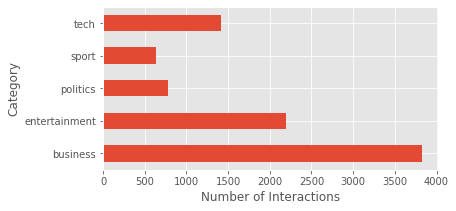

time: 200 ms


In [25]:
plt.rc('figure', figsize=[6, 3])

qlog[['query', 'category']] \
    .groupby('category') \
    .count() \
    .plot(kind='barh', legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Category')
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Distribution of query topics

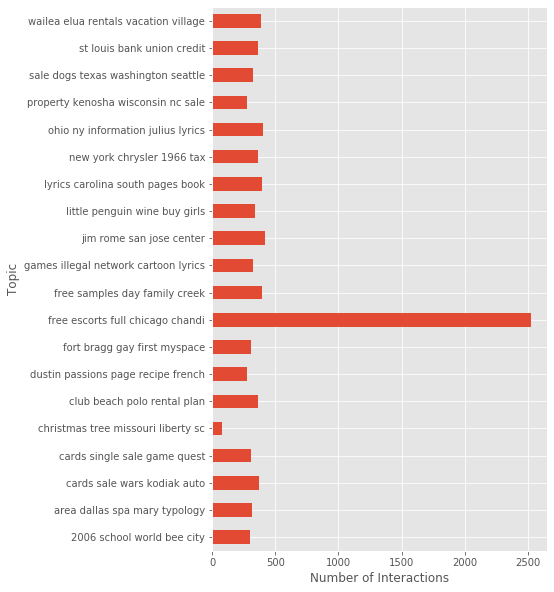

time: 338 ms


In [26]:
plt.rc('figure', figsize=[6, 10])

qlog[['query', 'topic']] \
    .groupby('topic') \
    .count() \
    .plot(kind='barh', legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Topic')
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Distribution of query categories over time

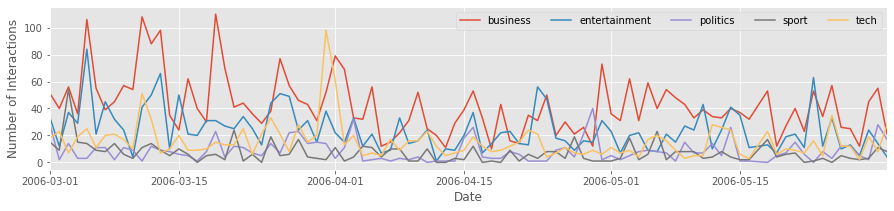

time: 276 ms


In [27]:
categories_over_time = qlog[['query', 'category', 'date']] \
    .groupby(['category', 'date']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('date') \
    .drop('level_0', axis=1) \
    .fillna(0)

categories_over_time.plot()
plt.legend(loc='upper right', ncol=5)
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

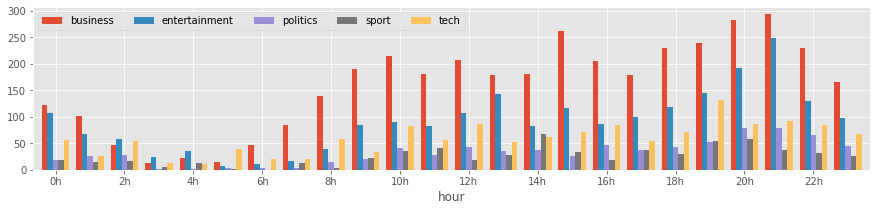

time: 436 ms


In [28]:
qlog[['query', 'category', 'hour']] \
    .groupby(['category', 'hour']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('hour') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=6)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)], rotation=0)
plt.show()

### Per weekday cycles

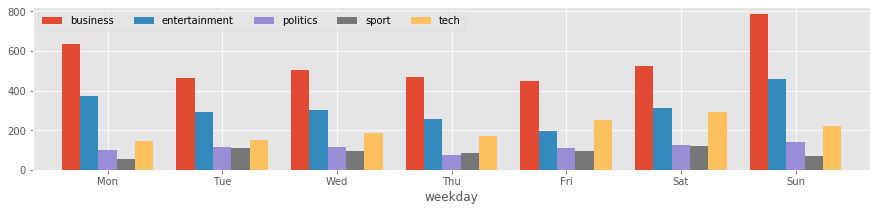

time: 264 ms


In [29]:
qlog[['query', 'category', 'weekday']] \
    .groupby(['category', 'weekday']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('weekday') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=6)
plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.show()

### Per monthly cycles

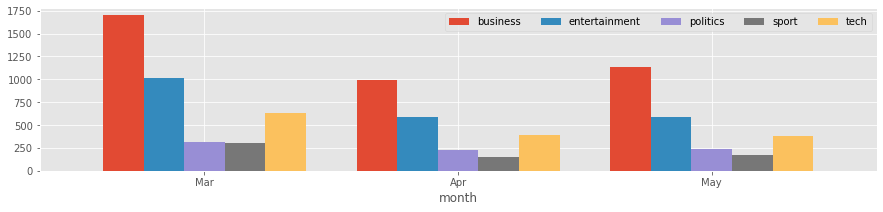

time: 263 ms


In [30]:
qlog[['query', 'category', 'month']] \
    .groupby(['category', 'month']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('month') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper right', ncol=6)
plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.show()

## Distribution of query topics over time for top-4 topics

In [31]:
top_topics = qlog[['query', 'topic']] \
    .groupby('topic') \
    .count() \
    .sort_values(by="query", ascending=False) \
    .rename({'query': 'count'}, axis=1) \
    .head(4)

time: 10.1 ms


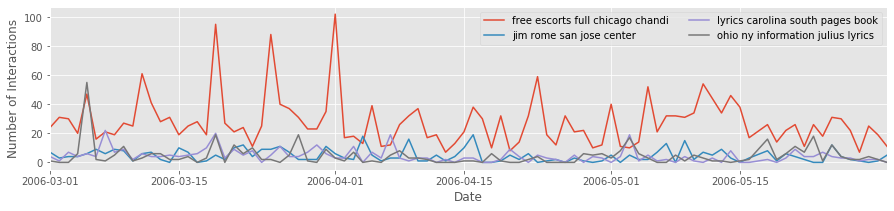

time: 382 ms


In [32]:
topics_over_time = qlog[['query', 'topic', 'date']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'date']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('date') \
    .drop('level_0', axis=1) \
    .fillna(0)

topics_over_time.plot()
plt.legend(loc='upper right', ncol=2)
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

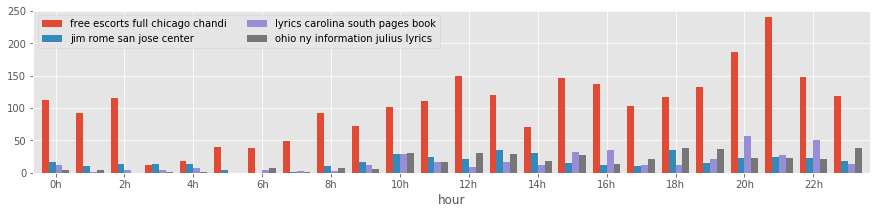

time: 440 ms


In [33]:
qlog[['topic', 'hour']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'hour']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('hour') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=2)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)], rotation=0)
plt.show()

### Per weekday cycles

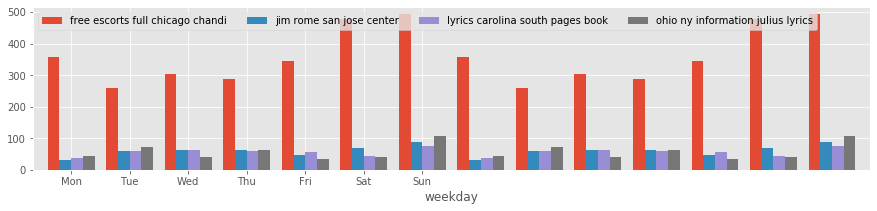

time: 398 ms


In [34]:
qlog[['query', 'topic', 'weekday']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'weekday']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('weekday') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=4)
plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.show()

### Per monthly cycles

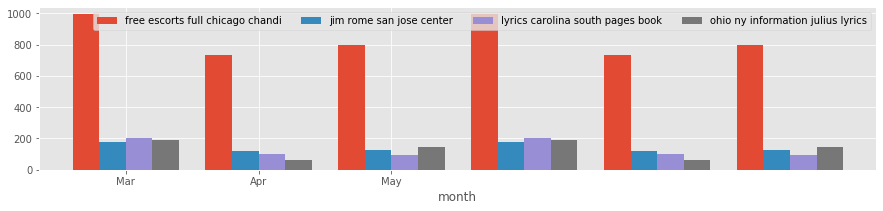

time: 240 ms


In [35]:
qlog[['query', 'topic', 'month']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'month']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('month') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper right', ncol=4)
plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.show()

# Session-level analysis

- Number of queries / interactions per session
- Number of distinct queries per session
- Session duration distribution
- Distribution of number of clicks per session
- Average clicked rank per session duration


- Average session duration:
  - Per day
  - For 24h cycles
  - For weekday cycles
  - For monthly cycles

## Detecting sessions

**Note:** Don't run the following code block if there is already a `session_id` column.

In [36]:
from datetime import timedelta

def detect_sessions(qlog, mins=30):
    qlog.drop('session_id', axis=1, errors='ignore', inplace=True)
    new_sessions = pd.Series([], dtype='int64')
    for _, user_qlog in qlog.sort_values(by=['user_id', 'timestamp']).groupby('user_id'):
        user_new_sessions = user_qlog.timestamp.gt(user_qlog.timestamp.shift() + timedelta(minutes=mins))
        user_new_sessions.iloc[0] = True
        new_sessions = new_sessions.append(user_new_sessions)
    return pd.concat([
        qlog.sort_values(by=['user_id', 'timestamp']),
        pd.DataFrame({ 'session_id': new_sessions.cumsum() })
    ], axis=1, sort=False)

qlog = detect_sessions(qlog); qlog[['user_id', 'query', 'timestamp', 'session_id']]

,user_id,query,timestamp,session_id
0,38534,maryland state police,2006-03-01 23:48:15,1
1,38534,harford county sheriff,2006-03-01 23:55:13,1
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1
...,...,...,...,...
8834,24797984,fw signs from god,2006-05-29 15:43:49,2546
8835,24797984,fw signs from god,2006-05-29 15:44:27,2546
8836,24797984,fw signs from god,2006-05-29 15:44:31,2546
8837,24797984,fw signs from god,2006-05-29 15:44:38,2546


time: 275 ms


## Number of interactions per session

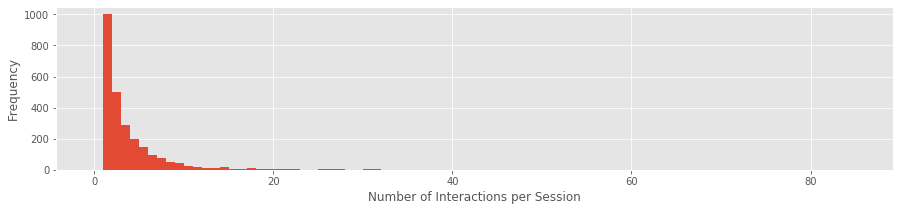

time: 322 ms


In [37]:
queries_per_session = qlog[['session_id', 'query']] \
    .groupby('session_id') \
    .count()

d_max = queries_per_session['query'].max()
bin_width = 1

queries_per_session \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), legend=False)
plt.xlabel("Number of Interactions per Session")
plt.ylabel("Frequency")
plt.show()

## Number of distinct queries per session

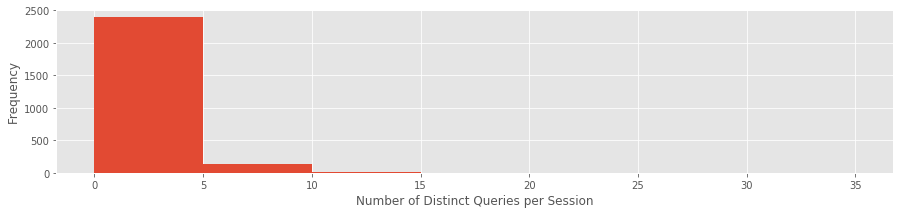

time: 223 ms


In [38]:
distinct_queries_per_session = qlog[['session_id', 'query']] \
    .groupby('session_id') \
    .nunique()

distinct_queries_per_session['session_id'] = distinct_queries_per_session.index
distinct_queries_per_session.drop('session_id', axis=1, inplace=True)
distinct_queries_per_session = distinct_queries_per_session.reset_index().drop('session_id', axis=1)

d_max = distinct_queries_per_session['query'].max()
bin_width = 5

distinct_queries_per_session \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), legend=False)
plt.xlabel("Number of Distinct Queries per Session")
plt.ylabel("Frequency")
plt.show()

## Session duration distribution

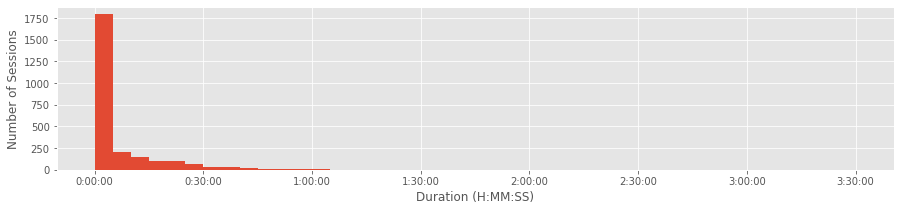

time: 1.19 s


In [39]:
from matplotlib.ticker import FuncFormatter

session_durations = qlog[['session_id', 'timestamp']] \
    .groupby('session_id') \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1)

d_max = session_durations['duration'].max()
bin_width = 5/60

ax = session_durations \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width), legend=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: timedelta(seconds=x * 3600)))
plt.xlabel("Duration (H:MM:SS)")
plt.ylabel("Number of Sessions")
plt.show()

## Distribution of number of clicks per session

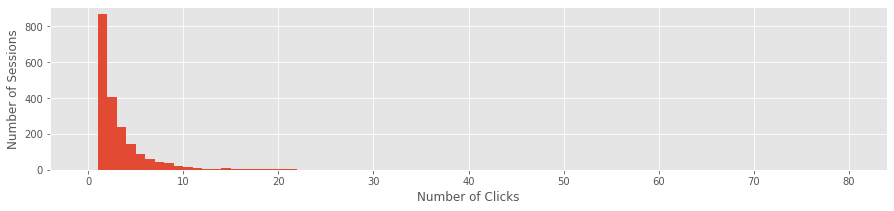

time: 338 ms


In [40]:
session_clicks = qlog[~qlog['click_rank'].isnull()][['session_id', 'click_rank']] \
    .groupby('session_id') \
    .count() \
    .reset_index() \
    .drop('session_id', axis=1) \
    .rename({ 'click_rank': 'click_count' }, axis=1)

d_max = session_clicks['click_count'].max()
bin_width = 1

session_clicks \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), logy=False, legend=False)
plt.xlabel("Number of Clicks")
plt.ylabel("Number of Sessions")
plt.show()

## Average session duration

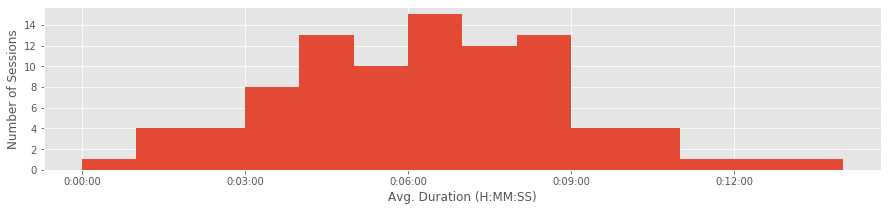

time: 1.24 s


In [41]:
from matplotlib.ticker import FuncFormatter

session_durations_per_day = qlog[['session_id', 'date', 'timestamp']] \
    .groupby(['session_id', 'date']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('date') \
    .mean()

d_max = session_durations_per_day['duration'].max()
bin_width = 1/60

ax = session_durations_per_day \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width), legend=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=hour * 3600)))
plt.xlabel("Avg. Duration (H:MM:SS)")
plt.ylabel("Number of Sessions")
plt.show()

### Per 24h cycles

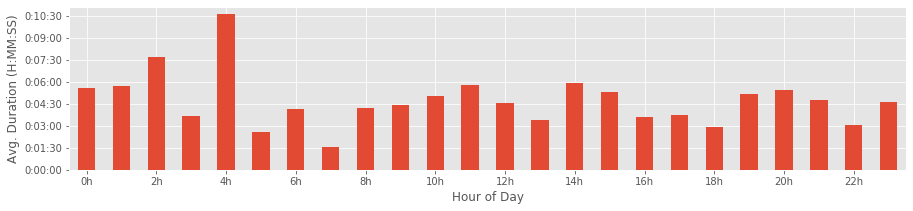

time: 1.32 s


In [42]:
from matplotlib.ticker import FuncFormatter

session_durations_per_hour_of_day = qlog[['session_id', 'hour', 'timestamp']] \
    .groupby(['session_id', 'hour']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('hour') \
    .mean()

ax = session_durations_per_hour_of_day \
    .plot(kind='bar', legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=int(hour * 3600))))
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)], rotation=0)
plt.xlabel("Hour of Day")
plt.ylabel("Avg. Duration (H:MM:SS)")
plt.show()

### Per weekday cycles

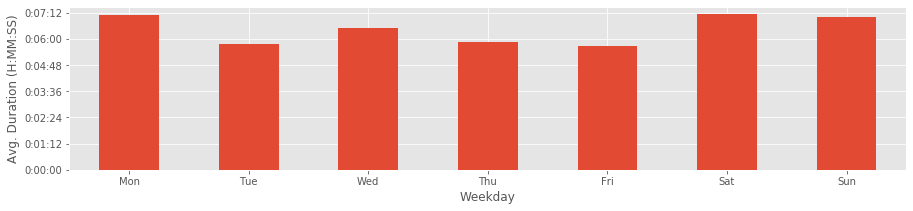

time: 1.1 s


In [43]:
from matplotlib.ticker import FuncFormatter

session_durations_per_weekday = qlog[['session_id', 'weekday', 'timestamp']] \
    .groupby(['session_id', 'weekday']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('weekday') \
    .mean()

ax = session_durations_per_weekday \
    .plot(kind='bar', legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=int(hour * 3600))))
plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.xlabel("Weekday")
plt.ylabel("Avg. Duration (H:MM:SS)")
plt.show()

### Per monthly cycles

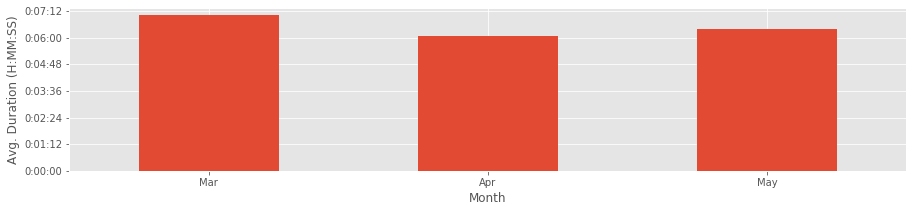

time: 1.07 s


In [44]:
from matplotlib.ticker import FuncFormatter

session_durations_per_month = qlog[['session_id', 'month', 'timestamp']] \
    .groupby(['session_id', 'month']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('month') \
    .mean()

ax = session_durations_per_month \
    .plot(kind='bar', legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=int(hour * 3600))))
plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.xlabel('Month')
plt.ylabel("Avg. Duration (H:MM:SS)")
plt.show()

## Average clicked rank per session duration

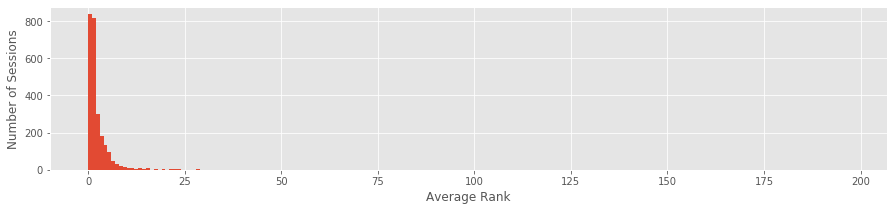

time: 1.2 s


In [140]:
session_avg_rank = qlog[['session_id', 'click_rank']] \
    .fillna(0) \
    .groupby('session_id') \
    .mean() \
    .reset_index() \
    .drop('session_id', axis=1) \
    .rename({ 'click_rank': 'avg_rank' }, axis=1)

d_max = int(np.ceil(session_avg_rank['avg_rank'].max()))
bin_width = 1

session_avg_rank \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), logy=False, legend=False)
plt.xlabel("Average Rank")
plt.ylabel("Number of Sessions")
plt.show()

# Term-level analysis

The term-level analysis is concerned with the characteristics of the words that form the queries. Our analysis includes:

- Distribution of number of characters per query
- Distribution of number of terms per query
- Distribution of average number of terms over time
- Term popularity over time for top terms

## Distribution of number of characters per query

In [46]:
qlog['length'] = qlog['query'].map(len); qlog[['query', 'length']]

,query,length
0,maryland state police,21
1,harford county sheriff,22
2,aberdeen police department in maryland,38
3,aberdeen police department in maryland,38
...,...,...
8834,fw signs from god,17
8835,fw signs from god,17
8836,fw signs from god,17
8837,fw signs from god,17


time: 21.1 ms


In [47]:
qlog['length'].describe()

count    8838.000000
mean       18.574904
std        10.300970
min         1.000000
25%        11.000000
50%        16.000000
75%        24.000000
max        96.000000
Name: length, dtype: float64

time: 15.8 ms


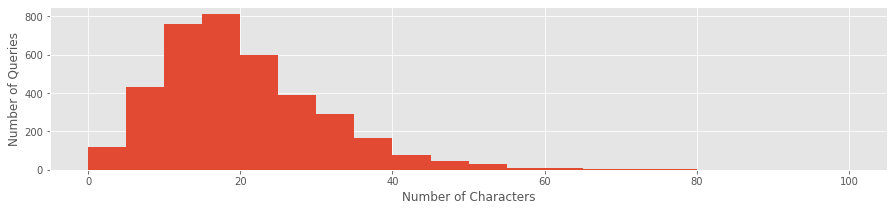

time: 229 ms


In [152]:
d_max = qlog['length'].max()
bin_width = 5

qlog.drop_duplicates(subset='query')['length'] \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width))
plt.xlabel("Number of Characters")
plt.ylabel("Number of Queries")
plt.show()

## Distribution of number of terms per query

In [154]:
qlog['terms'] = qlog['query'].map(lambda q: q.split()); qlog[['query', 'terms']]

,query,terms
0,maryland state police,"[maryland, state, police]"
1,harford county sheriff,"[harford, county, sheriff]"
2,aberdeen police department in maryland,"[aberdeen, police, department, in, maryland]"
3,aberdeen police department in maryland,"[aberdeen, police, department, in, maryland]"
...,...,...
8834,fw signs from god,"[fw, signs, from, god]"
8835,fw signs from god,"[fw, signs, from, god]"
8836,fw signs from god,"[fw, signs, from, god]"
8837,fw signs from god,"[fw, signs, from, god]"


time: 23.4 ms


In [50]:
qlog['num_terms'] = qlog['terms'].map(len); qlog[['query', 'num_terms']]

,query,num_terms
0,maryland state police,3
1,harford county sheriff,3
2,aberdeen police department in maryland,5
3,aberdeen police department in maryland,5
...,...,...
8834,fw signs from god,4
8835,fw signs from god,4
8836,fw signs from god,4
8837,fw signs from god,4


time: 22.6 ms


In [51]:
qlog['num_terms'].describe()

count    8838.000000
mean        2.911858
std         1.699581
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        16.000000
Name: num_terms, dtype: float64

time: 9.02 ms


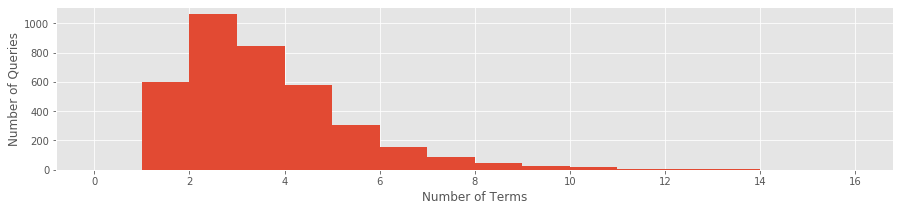

time: 240 ms


In [155]:
d_max = qlog['num_terms'].max()
bin_width = 1

qlog.drop_duplicates(subset='query')['num_terms'] \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width))
plt.xlabel("Number of Terms")
plt.ylabel("Number of Queries")
plt.show()

## Distribution of average number of terms over time

In [53]:
expanded_terms = qlog[['date', 'terms']] \
    .set_index('date')['terms'] \
    .apply(pd.Series) \
    .stack()

time: 2.22 s


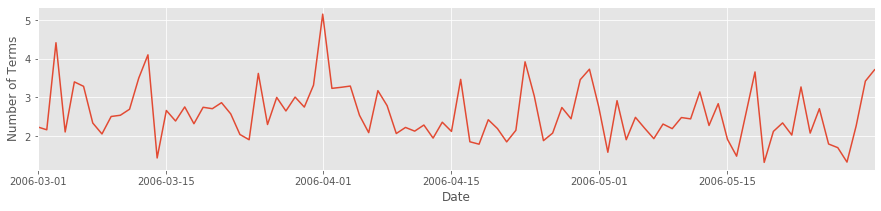

time: 213 ms


In [161]:
term_count = expanded_terms \
    .groupby('date') \
    .value_counts()

d_max = term_count.max()
bin_width = 1

term_count \
    .groupby(level=0) \
    .mean() \
    .plot()
plt.xlabel('Date')
plt.ylabel('Number of Terms')
plt.show()

## Term popularity over time for top 10 terms

In [55]:
vec = TfidfVectorizer()
X = vec.fit_transform(qlog['query'])
vocab = vec.get_feature_names()
top_terms = pd.DataFrame(X.toarray(), columns=vocab) \
    .drop(stopwords_per_lang[lang].intersection(vocab), axis=1) \
    .mean() \
    .sort_values(ascending=False)

top_terms[:5]

google       0.024779
gardenweb    0.012257
free         0.010483
lyrics       0.008693
cards        0.007693
dtype: float64

time: 368 ms


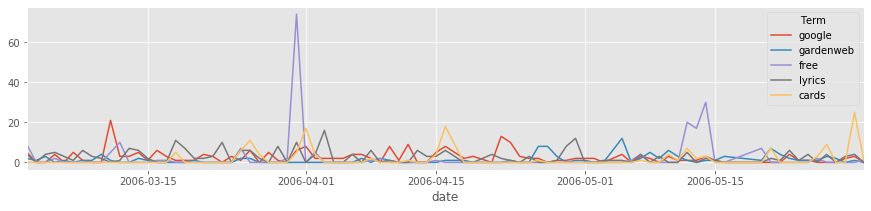

time: 327 ms


In [56]:
term_cout_over_time = pd.DataFrame(expanded_terms[expanded_terms.isin(top_terms[:5].index)], columns=['term']) \
    .reset_index() \
    .groupby(['date', 'term']) \
    .count() \
    .rename({'level_1': 'count'}, axis=1) \
    .unstack() \
    .fillna(0)

term_cout_over_time.columns = term_cout_over_time.columns.droplevel()

term_cout_over_time.loc[:, top_terms[:5].index] \
    .plot()
plt.legend(title='Term')
plt.show()

# Entity-level analysis

Our analysis of entities includes:

- Entity distributions per class
- Entity distributions over time for top entities

It also includes higher order analyses, further described in each of the following sections:

- Entity-query-level analysis
- Entity-topic-level analysis
- Entity-session-level analysis
- Entity-term-level analysis
- Entity-entity level analysis

## Detecting entities

We identified entities taking advantage of the `AhoCorasickEntityExtractor` class available in [Army ANT](https://github.com/feup-infolab/army-ant). We copied [aho_corasick_entity_extractor.py](../../edit/query_log_analysis/aho_corasick_entity_extractor.py) to the notebook workspace and edited it to be usable as a standalone dependency. We then used the English DBpedia `rdfs:label` for entities with the class `dbo:Person`, `dbo:Organisation` and `dbp:Place` as the dictionary.

In [57]:
from aho_corasick_entity_extractor import AhoCorasickEntityExtractor

lists_per_lang = {
    'en': {
        'person': 'data/entity_lists/pt_dbpedia_person.txt',
        'organization': 'data/entity_lists/pt_dbpedia_organization.txt',
        'place': 'data/entity_lists/pt_dbpedia_place.txt'
    },
    'pt': {
        'person': 'data/entity_lists/en_dbpedia_person.txt',
        'organization': 'data/entity_lists/en_dbpedia_organization.txt',
        'place': 'data/entity_lists/en_dbpedia_place.txt'
    }
}

ac = {
    'person': AhoCorasickEntityExtractor(list_path=lists_per_lang[lang]['person']),
    'organization': AhoCorasickEntityExtractor(list_path=lists_per_lang[lang]['organization']),
    'place': AhoCorasickEntityExtractor(list_path=lists_per_lang[lang]['place'])
}

time: 1.41 s


In [58]:
qlog.iloc[19]['query']

'flamingo hotel las vegas'

time: 6.08 ms


In [59]:
from collections import OrderedDict
from functools import reduce

for d_class in ac.keys():
    qlog[d_class] = None

    for i in range(len(qlog)):
        query = qlog.iloc[i]['query']
        entities = ac[d_class].extract(query)
        
        for entity in entities:
            if qlog.loc[i, d_class] is None:
                qlog.at[i, d_class] = [entity]
            else:
                qlog.at[i, d_class].append(entity)

qlog

,user_id,query,timestamp,click_rank,click_url,date,hour,weekday,month,category,topic,session_id,length,terms,num_terms,person,organization,place
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org,2006-03-01,23,2,3,politics,lyrics carolina south pages book,1,21,"[maryland, state, police]",3,None,None,[maryland]
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org,2006-03-01,23,2,3,entertainment,free samples day family creek,1,22,"[harford, county, sheriff]",3,None,None,None
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics,lyrics carolina south pages book,1,38,"[aberdeen, police, department, in, maryland]",5,None,[aberdeen],"[maryland, aberdeen]"
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics,lyrics carolina south pages book,1,38,"[aberdeen, police, department, in, maryland]",5,None,[aberdeen],"[maryland, aberdeen]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN,2006-05-29,15,0,5,business,new york chrysler 1966 tax,2546,17,"[fw, signs, from, god]",4,None,None,None
8835,24797984,fw signs from god,2006-05-29 15:44:27,NaN,NaN,2006-05-29,15,0,5,business,new york chrysler 1966 tax,2546,17,"[fw, signs, from, god]",4,None,None,None
8836,24797984,fw signs from god,2006-05-29 15:44:31,NaN,NaN,2006-05-29,15,0,5,business,new york chrysler 1966 tax,2546,17,"[fw, signs, from, god]",4,None,None,None
8837,24797984,fw signs from god,2006-05-29 15:44:38,NaN,NaN,2006-05-29,15,0,5,business,new york chrysler 1966 tax,2546,17,"[fw, signs, from, god]",4,None,None,None


time: 5.76 s


## Entity distributions per class

In [162]:
qlog_entities = pd.DataFrame(columns=['entity', 'class', 'count'])

for d_class in ac.keys():
    entity_count = pd.DataFrame({
            'entity': list(itertools.chain(*filter(lambda d: d is not None, qlog[d_class]))),
            'class': d_class
        }) \
        .groupby(['entity', 'class']) \
        .size() \
        .reset_index() \
        .rename({0: 'count'}, axis='columns')
    
    qlog_entities = qlog_entities.append(entity_count)

time: 53.2 ms


### All classes

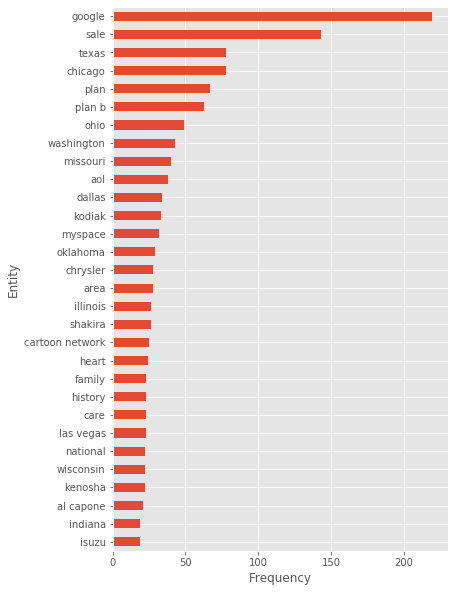

time: 411 ms


In [61]:
plt.rc('figure', figsize=[6, 10])

qlog_entities[['entity', 'count']] \
    .groupby('entity') \
    .sum() \
    .reset_index() \
    .sort_values(by='count', ascending=False) \
    .head(30) \
    .plot(kind='barh', x='entity', y='count', legend=False)

plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

### Person

In [62]:
def plot_entities_by_class(qlog_entities, d_class):
    plt.rc('figure', figsize=[6, 10])

    qlog_entities[qlog_entities['class'] == d_class] \
        .sort_values(by='count', ascending=False) \
        .head(30) \
        .plot(kind='barh', x='entity', y='count', legend=False)

    plt.xlabel('Frequency')
    plt.ylabel(d_class.title())
    plt.gca().invert_yaxis()
    plt.show()

    plt.rc('figure', figsize=DEFAULT_FIGSIZE)

time: 8.91 ms


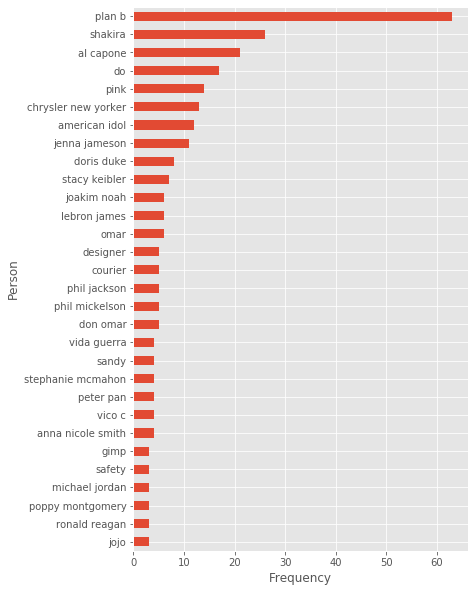

time: 345 ms


In [63]:
plot_entities_by_class(qlog_entities, 'person')

### Organization

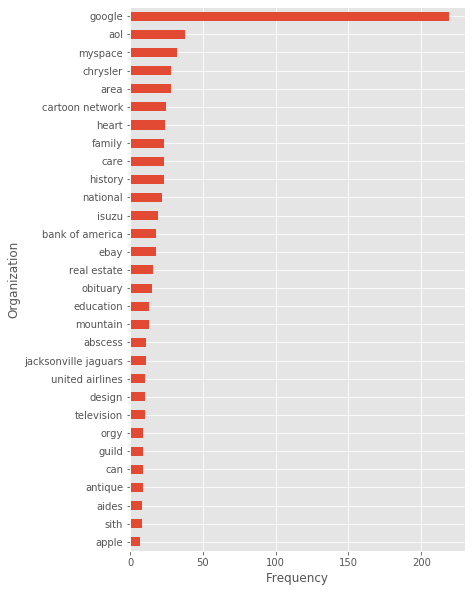

time: 328 ms


In [64]:
plot_entities_by_class(qlog_entities, 'organization')

### Place

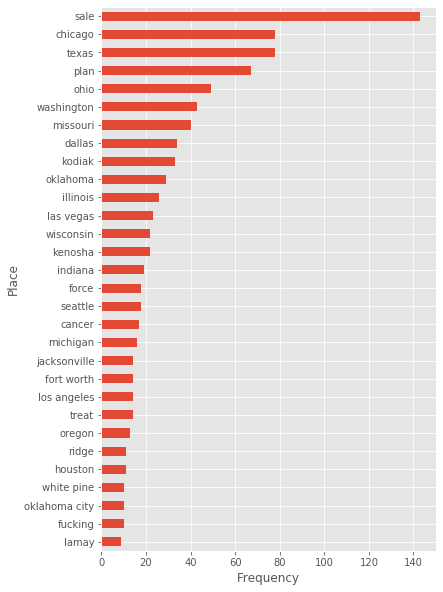

time: 326 ms


In [65]:
plot_entities_by_class(qlog_entities, 'place')

## Entity distributions over time for top-5 entities

In [208]:
def split_list_to_rows(row, row_accumulator, target_column):
    if row[target_column] == None:
        row[target_column] = []
    for s in row[target_column]:
        new_row = row.to_dict()
        new_row[target_column] = s
        row_accumulator.append(new_row)

time: 3.73 ms


In [220]:
new_rows = []
qlog[['date', 'entities']] \
    .apply(split_list_to_rows, axis=1, args = (new_rows, 'entities'))
entities_per_date = pd.DataFrame(new_rows)
entities_per_date \
    .groupby(['entities', 'date']) \
    .size() \
    .to_frame()

,,0
entities,date,
a static lullaby,2006-05-21,1
aaliyah,2006-04-29,1
abbott laboratories,2006-04-16,1
aberdeen,2006-03-01,4
...,...,...
wizards,2006-03-05,1
woodcrest,2006-03-25,1
xpress,2006-04-01,1
yes,2006-03-16,2


time: 731 ms


In [244]:
qlog_entities_over_time = pd.DataFrame(columns=['entity', 'class', 'count'])

for d_class in ac.keys():
    new_rows = []
    qlog[['date', d_class]] \
        .apply(split_list_to_rows, axis=1, args = (new_rows, d_class))
    entities_per_date = pd.DataFrame(new_rows) \
        .groupby([d_class, 'date']) \
        .size() \
        .to_frame() \
        .reset_index() \
        .rename(columns={d_class: 'entity', 0: 'count'}) \
        .assign(**{'class': d_class}) \
        .set_index(['date'])

    qlog_entities_over_time = qlog_entities_over_time.append(entities_per_date[['entity', 'class', 'count']])

qlog_entities_over_time

,entity,class,count
2006-04-29,aaliyah,person,1
2006-04-23,al capone,person,1
2006-04-29,al capone,person,2
2006-04-30,al capone,person,18
...,...,...,...
2006-03-27,wisconsin,place,1
2006-04-02,wisconsin,place,21
2006-03-25,woodcrest,place,1
2006-04-01,xpress,place,1


time: 1.39 s


### Person

In [247]:
top_5_person = qlog_entities[qlog_entities['class'] == 'person'] \
    .sort_values(by='count', ascending=False) \
    .head(5) \
    ['entity'].values.tolist()
top_5_person

['plan b', 'shakira', 'al capone', 'do', 'pink']

time: 6.43 ms


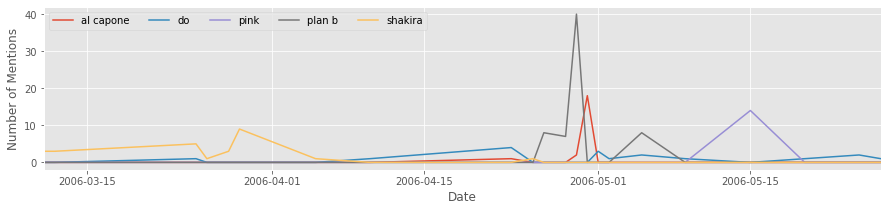

time: 260 ms


In [285]:
top_5_person_over_time = qlog_entities_over_time[qlog_entities_over_time['entity'].isin(top_5_person)] \
    [['entity', 'count']] \
    .pivot(columns='entity', values=['count']) \
    .fillna(0)

top_5_person_over_time.columns = top_5_person_over_time.columns.droplevel()

top_5_person_over_time.plot()
plt.legend(loc="upper left", ncol=5)
plt.xlabel("Date")
plt.ylabel("Number of Mentions")
plt.show()

### Organization

In [256]:
top_5_organization = qlog_entities[qlog_entities['class'] == 'organization'] \
    .sort_values(by='count', ascending=False) \
    .head(5) \
    ['entity'].values.tolist()
top_5_organization

['google', 'aol', 'myspace', 'chrysler', 'area']

time: 6.82 ms


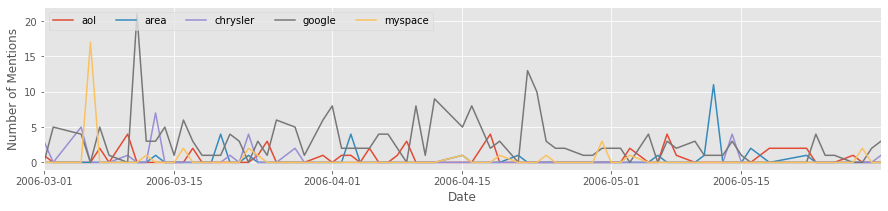

time: 275 ms


In [287]:
top_5_organization_over_time = qlog_entities_over_time[qlog_entities_over_time['entity'].isin(top_5_organization)] \
    [['entity', 'count']] \
    .pivot(columns='entity', values=['count']) \
    .fillna(0)

top_5_organization_over_time.columns = top_5_organization_over_time.columns.droplevel()

top_5_organization_over_time.plot()
plt.legend(loc="upper left", ncol=5)
plt.xlabel("Date")
plt.ylabel("Number of Mentions")
plt.show()

### Place

In [250]:
top_5_place = qlog_entities[qlog_entities['class'] == 'place'] \
    .sort_values(by='count', ascending=False) \
    .head(5) \
    ['entity'].values.tolist()
top_5_place

['sale', 'chicago', 'texas', 'plan', 'ohio']

time: 9.31 ms


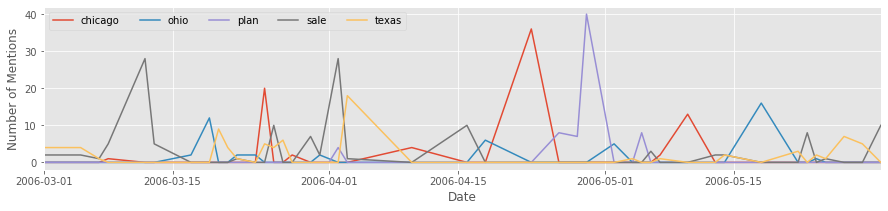

time: 297 ms


In [288]:
top_5_place_over_time = qlog_entities_over_time[qlog_entities_over_time['entity'].isin(top_5_place)] \
    [['entity', 'count']] \
    .pivot(columns='entity', values=['count']) \
    .fillna(0)

top_5_place_over_time.columns = top_5_place_over_time.columns.droplevel()

top_5_place_over_time.plot()
plt.legend(loc="upper left", ncol=5)
plt.xlabel("Date")
plt.ylabel("Number of Mentions")
plt.show()

In the following sections, we expand the entity-level analysis by combining them with additional levels. In particular, we build local entity graphs from mentioned entities in a query, in queries with the same topic, or in a session to gain further insights into user search behavior.

## Building and characterizing entity graph from Simple Wikipedia

We use the [Simple English Wikipedia Link Graph with Clickstream Transitions 2018-12](https://rdm.inesctec.pt/dataset/cs-2018-004) to analyze the data from DBpedia. On one side, this graph only contains a low number of entities from Wikipedia. On the other side, it's easier to load and process in memory, conveniently supporting this analysis, that can later on be scaled up to a larger Wikipedia link graph.

In [66]:
g = igraph.read('data/simplewiki_link_graph-201812.gml', format='gml')
g.vs['label'] = [label.lower() for label in g.vs['label']]

time: 47.4 s


In [67]:
g.vs['in'] = g.indegree()
g.vs['in'] = g.vs['in'] / np.sum(g.vs['in']) # indegree centrality (i.e., normalized)
g.vs['pr'] = g.pagerank()

time: 3.63 s


In [68]:
@memory.cache
def compute_stats(graph=None, include_distance_based=False):
    if graph is None:
        graph = g
    
    components = graph.components()
    
    stats = {
        'vertices': graph.vcount(),
        'edges': graph.ecount(),
        'avg_clust_coef': graph.transitivity_undirected(),
        'density': graph.density(),
        'num_cc': len(components),
        'avg_cc_size': np.mean(components.sizes()),
        'stdev_cc_size': np.std(components.sizes())
    }
    
    if include_distance_based:
        stats['diameter'] = graph.diameter()
        stats['avg_path_len'] = graph.average_path_length()
    
    return pd.Series(stats)

g_stats = compute_stats(); g_stats.round(2)

vertices           897577.00
edges             6986460.00
avg_clust_coef          0.26
density                 0.00
num_cc             743499.00
avg_cc_size             1.21
stdev_cc_size         177.54
dtype: float64

time: 30 ms


## Building and visualizing entity subgraphs induced by a set of entities

We extract the induced entity subgraph for a set of entities, including all edges between the respective entity nodes. We also annotate and color source entity nodes, as well as shortest path edges (indiscriminately for any shortest path edges).

In [69]:
def entity_subgraph(entities, sample=None, ignore_warn=False):
    if sample is not None:
        entities = np.random.choice(list(entities), size=np.min([len(entities), sample]), replace=False)

    v_entities = g.vs.select(label_in=entities)
    
    s_paths = []
    for v_entity in v_entities:
        s_paths.extend(g.get_shortest_paths(v_entity, to=v_entities))

    sg = g.induced_subgraph([v for s_path in s_paths for v in s_path])
    
    sg.vs['is_source'] = False
    sg.vs['color'] = '#85c1e9'
    sg.es['arrow_size'] = 0.5

    sources = sg.vs.select(label_in=v_entities['label'])
    sources['is_source'] = True
    sources['color'] = '#f7dc6f'
    
    sp_edges = []
    for s_path in s_paths:
        if len(s_path) < 2:
            continue

        for s_idx, t_idx in zip(range(len(s_path)-1), range(1, len(s_path))):
            source = sg.vs.find(label=g.vs[s_path[s_idx]]['label'])
            target = sg.vs.find(label=g.vs[s_path[t_idx]]['label'])

            try:
                sp_edge = sg.es.find(_source=source.index, _target=target.index)
                sp_edge['arrow_size'] = 0.75
                sp_edge['width'] = 1.5
                sp_edge['color'] = '#f7dc6f'
                sp_edges.append(sp_edge)
            except:
                if not ignore_warn:
                    warnings.warn("Edge linking %s and %s not found" % (source['label'], target['label']))

    return sg

time: 96.7 ms


In [70]:
def plot_subgraph(sg, large=False):
    if large:
        bbox = (640, 480)
        margin = (50, 100, 50, 100)
    else:
        bbox = (320, 240)
        margin = (25, 50, 25, 50)

    return igraph.plot(sg, bbox=bbox, margin=margin, vertex_size=10, vertex_label_size=10, vertex_label_dist=1.5)

time: 15.8 ms


# Entity-query-level analysis

- Distribution of entities per query
- Distribution of global entity importance (PageRank) per query
- Distribution of local entity importance (PageRank) per query
- Number of distinct queries per entity

## Distribution of entities per query

In [71]:
entities = qlog[['person', 'organization', 'place']].values.tolist()  # select all entity lists
entities = [[x if x else [] for x in d] for d in entities]            # replace None by empty list
entities = [[x for sl2 in sl for x in sl2 if sl2] for sl in entities] # flatten row lists

qlog['entities'] = None
for i, e in enumerate(entities):
    qlog.at[i, 'entities'] = e if len(e) > 0 else None

time: 332 ms


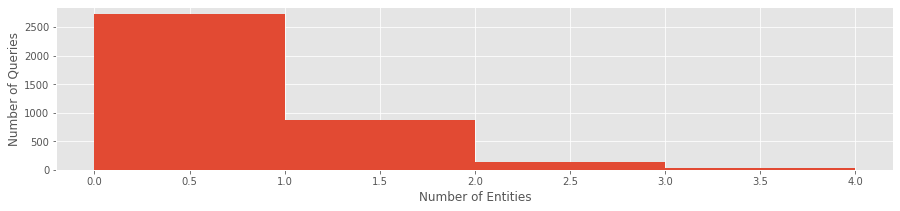

time: 563 ms


In [72]:
entities_per_query = qlog[['query', 'entities']] \
    .groupby('query') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 1

entities_per_query \
    .plot(kind='hist', bins=range(0, entities_per_query.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Queries")
plt.show()

## Preparing entity subgraphs per query

In [73]:
qlog[qlog['num_terms'] < qlog['num_terms'].max()]

,user_id,query,timestamp,click_rank,click_url,date,hour,weekday,month,category,topic,session_id,length,terms,num_terms,person,organization,place,entities
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org,2006-03-01,23,2,3,politics,lyrics carolina south pages book,1,21,"[maryland, state, police]",3,None,None,[maryland],[maryland]
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org,2006-03-01,23,2,3,entertainment,free samples day family creek,1,22,"[harford, county, sheriff]",3,None,None,None,None
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics,lyrics carolina south pages book,1,38,"[aberdeen, police, department, in, maryland]",5,None,[aberdeen],"[maryland, aberdeen]","[aberdeen, maryland, aberdeen]"
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics,lyrics carolina south pages book,1,38,"[aberdeen, police, department, in, maryland]",5,None,[aberdeen],"[maryland, aberdeen]","[aberdeen, maryland, aberdeen]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN,2006-05-29,15,0,5,business,new york chrysler 1966 tax,2546,17,"[fw, signs, from, god]",4,None,None,None,None
8835,24797984,fw signs from god,2006-05-29 15:44:27,NaN,NaN,2006-05-29,15,0,5,business,new york chrysler 1966 tax,2546,17,"[fw, signs, from, god]",4,None,None,None,None
8836,24797984,fw signs from god,2006-05-29 15:44:31,NaN,NaN,2006-05-29,15,0,5,business,new york chrysler 1966 tax,2546,17,"[fw, signs, from, god]",4,None,None,None,None
8837,24797984,fw signs from god,2006-05-29 15:44:38,NaN,NaN,2006-05-29,15,0,5,business,new york chrysler 1966 tax,2546,17,"[fw, signs, from, god]",4,None,None,None,None


time: 50.3 ms


In [74]:
def entities_from_query(query):
    return set(flatten(
        qlog[qlog['query'] == query] \
            ['entities'].values.tolist()))

entities_from_query('aberdeen police department in maryland')

{'aberdeen', 'maryland'}

time: 15.8 ms


In [75]:
@memory.cache
def get_entity_subgraphs_by_query(queries):
    eg = {}
    for query in progressbar.progressbar(queries):
        entities = entities_from_query(query)
        if entities:
            eg[query] = entity_subgraph(entities, ignore_warn=True)
            eg[query].vs['lpr'] = eg[query].pagerank()    
    return eg

eg = get_entity_subgraphs_by_query(qlog['query'].unique())

time: 173 ms


## Visualizing entity subgraphs for queries

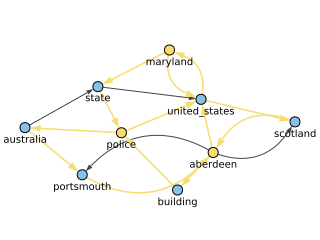

time: 43.1 ms


In [76]:
plot_subgraph(eg['aberdeen police department in maryland'])

## Distribution of global entity importance (PageRank) per query

In [77]:
all_queries_pr = pd.concat(
    pd.DataFrame({ 'query': query, 'pr': eg[query].vs['pr'], 'lpr': eg[query].vs['lpr'] })
    for query in eg.keys())

all_queries_pr = all_queries_pr \
    .groupby('query') \
    .mean()

all_queries_pr

,pr,lpr
query,,
10 passenger vans for rent in seattle wa. airport,0.000296,0.111111
10-99 tax form,0.000064,1.000000
1099 tax form,0.000064,1.000000
1966 chrysler,0.000007,1.000000
...,...,...
yochi designer dogs for sale,0.000005,1.000000
ywam canada,0.000468,1.000000
zion national park,0.000018,1.000000
zip codes in texas,0.000147,1.000000


time: 1.43 s


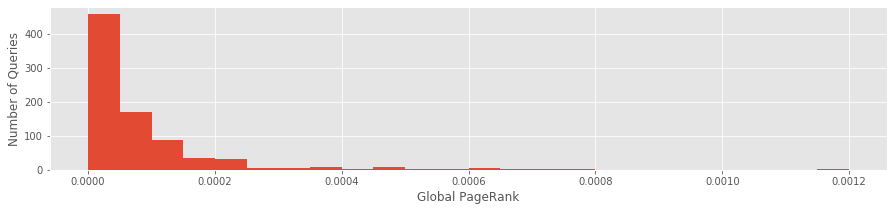

time: 223 ms


In [78]:
d_max = all_queries_pr['pr'].max()
bin_width = 0.00005

all_queries_pr['pr'] \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width))
plt.xlabel('Global PageRank')
plt.ylabel('Number of Queries')
plt.show()

## Distribution of local entity importance (PageRank) per query

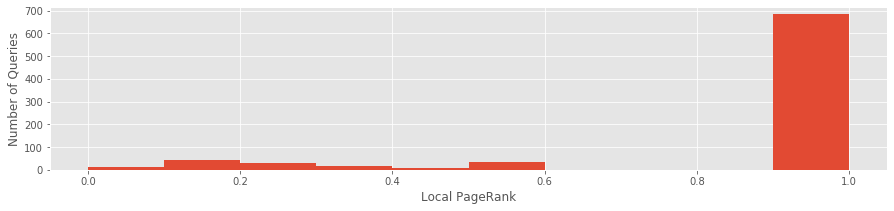

time: 210 ms


In [79]:
d_max = all_queries_pr['lpr'].max()
bin_width = 0.1

all_queries_pr['lpr'] \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width))
plt.xlabel('Local PageRank')
plt.ylabel('Number of Queries')
plt.show()

## Number of distinct queries per entity (top 25)

In [80]:
queries_per_entity = qlog[['query', 'entities']] \
    .groupby('query') \
    .first() \
    .reset_index()

null_idx = queries_per_entity.index[queries_per_entity['entities'].isnull()]

for idx in null_idx:
    queries_per_entity['entities'].at[idx] = []

queries_per_entity = pd.DataFrame([
    (row.query, entity) for row in queries_per_entity.itertuples() for entity in row.entities],
    columns=['query', 'entity'])

queries_per_entity = queries_per_entity[['entity', 'query']] \
    .groupby('entity') \
    .count() \
    .sort_values(ascending=False, by='query') \
    .head(25)

queries_per_entity

,query
entity,
texas,47
sale,34
aol,26
ohio,20
...,...
kodiak,9
television,8
plan b,8
shakira,8


time: 85.1 ms


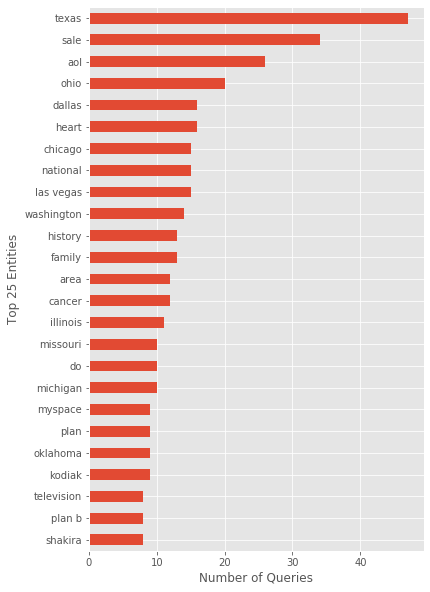

time: 300 ms


In [81]:
plt.rc('figure', figsize=[6, 10])

queries_per_entity['query'] \
    .plot(kind='barh')
plt.xlabel('Number of Queries')
plt.ylabel('Top 25 Entities')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

# Entity-topic-level analysis

- Distribution of entities per category
- Distribution of entity importance (PageRank) per category
- Distribution of categories per entity


- Distribution of entities per topic
- Distribution of distinct entities per topic
- Distribution of entity importance (PageRank) per topic
- Distribution of topics per entity

## Categories

### Distribution of entities per category

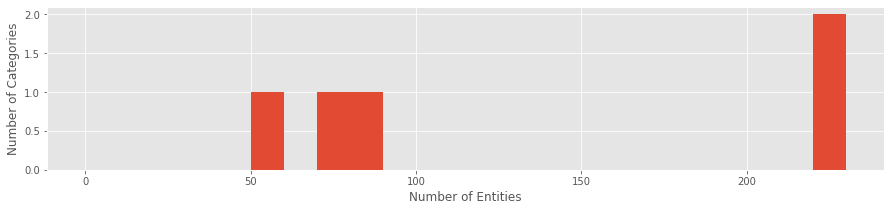

time: 243 ms


In [82]:
entities_per_category = qlog[['category', 'entities']] \
    .groupby('category') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 10

entities_per_category \
    .plot(kind='hist', bins=range(0, entities_per_category.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Categories")
plt.show()

### Preparing entity subgraphs per category

In [83]:
def entities_from_category(category):
    return set(flatten(
        qlog[qlog['category'] == category] \
            ['entities'].values.tolist()))

entities_from_category('business')

{'abscess',
 'agen',
 'air china',
 'al capone',
 'alabama',
 'americana',
 'angelina jolie',
 'annot',
 'aol',
 'arbonne',
 'area',
 'arena',
 'arizona',
 'azu',
 'bakassi',
 'baltimore',
 'bank of america',
 'banki',
 'barn',
 'boca raton',
 'boynton',
 'boynton beach',
 'bread',
 'bronx',
 'brooklyn',
 'buffalo',
 'buffalo bills',
 'burren',
 'can',
 'cancer',
 'care',
 'cemetary',
 'chattanooga',
 'chevrolet',
 'chevron',
 'chicago',
 'chihuahua',
 'china',
 'chowchilla',
 'chrysler',
 'chrysler new yorker',
 'cnn',
 'coachella',
 'colorado',
 'como',
 'conor oberst',
 'courier',
 'couture',
 'cowboy',
 'craigslist',
 'cutting',
 'dallas',
 'deepak chopra',
 'delaware',
 'denver',
 'derma',
 'designer',
 'do',
 'dodge',
 'doris duke',
 'drugstore',
 'earl monroe',
 'el salvador',
 'elk horn',
 'eros',
 'facebook',
 'falkenberg',
 'fall out boy',
 'falmouth',
 'family',
 'fastweb',
 'fluid',
 'food and drug administration',
 'force',
 'former',
 'fort worth',
 'fresno',
 'frontier a

time: 17.1 ms


In [84]:
@memory.cache
def get_entity_subgraphs_by_category(categories, sample=None):
    eg = {}
    for category in progressbar.progressbar(categories):
        entities = entities_from_category(category)
        if entities:
            eg[category] = entity_subgraph(entities, sample=sample, ignore_warn=True)
            eg[category].vs['lpr'] = eg[category].pagerank()    
    return eg

eg = get_entity_subgraphs_by_category(qlog['category'].unique(), sample=100)

time: 679 ms


### Distribution of global entity importance (PageRank) per category

In [85]:
all_categories_pr = pd.concat(
    pd.DataFrame({ 'category': category, 'pr': eg[category].vs['pr'], 'lpr': eg[category].vs['lpr'] })
    for category in eg.keys())

all_categories_pr

,category,pr,lpr
0,politics,2.450089e-04,0.003141
1,politics,4.568679e-05,0.000963
2,politics,2.497937e-05,0.001047
3,politics,5.858973e-05,0.000433
...,...,...,...
859,sport,6.619256e-07,0.000212
860,sport,6.497524e-07,0.000183
861,sport,8.140439e-07,0.000216
862,sport,7.751282e-07,0.000294


time: 23 ms


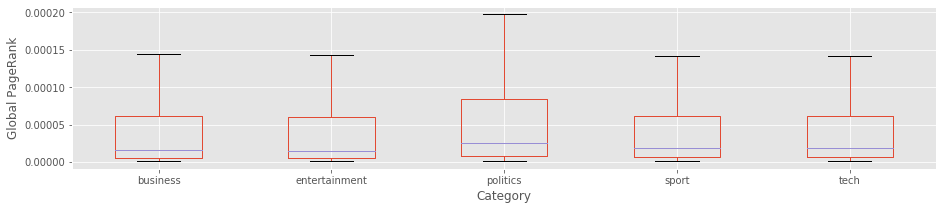

time: 365 ms


In [86]:
all_categories_pr[['category', 'pr']] \
    .boxplot(by='category', showfliers=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Global PageRank")
plt.show()

### Distribution of local entity importance (PageRank) per category

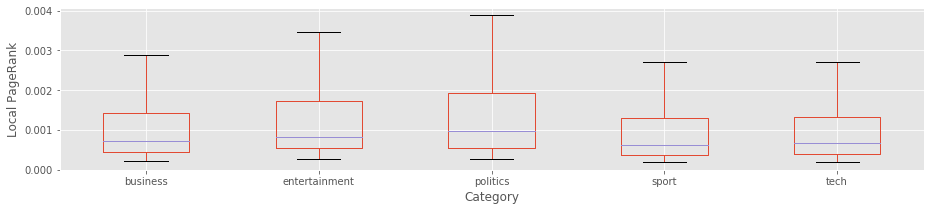

time: 392 ms


In [87]:
all_categories_pr[['category', 'lpr']] \
    .boxplot(by='category', showfliers=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Local PageRank")
plt.show()

### Distribution of categories per entity (top 25)

In [88]:
categories_per_entity = qlog[['category', 'entities']]

null_idx = categories_per_entity.index[categories_per_entity['entities'].isnull()]

for idx in null_idx:
    categories_per_entity['entities'].at[idx] = []

categories_per_entity = pd.DataFrame([
    (row.category, entity) for row in categories_per_entity.itertuples() for entity in row.entities],
    columns=['category', 'entity'])

categories_per_entity = categories_per_entity[['entity', 'category']] \
    .groupby('entity') \
    .nunique()[['category']] \
    .sort_values(ascending=False, by="category") \
    .head(25)

categories_per_entity

,category
entity,
texas,5
aol,4
chicago,4
ohio,4
...,...
sale,3
valley,3
jacksonville,3
lansing,3


time: 122 ms


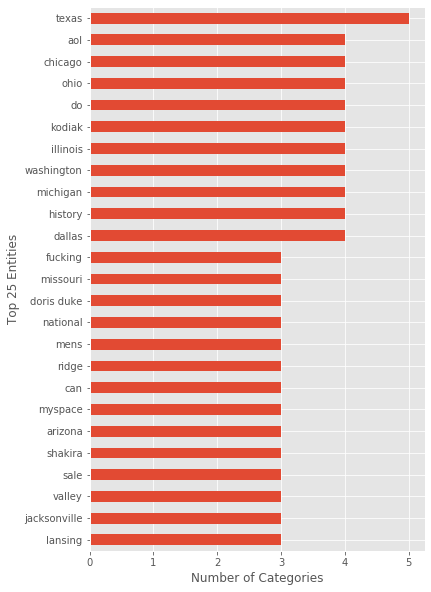

time: 290 ms


In [89]:
plt.rc('figure', figsize=[6, 10])

categories_per_entity['category'] \
    .plot(kind='barh')
plt.xlabel('Number of Categories')
plt.ylabel('Top 25 Entities')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Topics

### Distribution of entities per topic

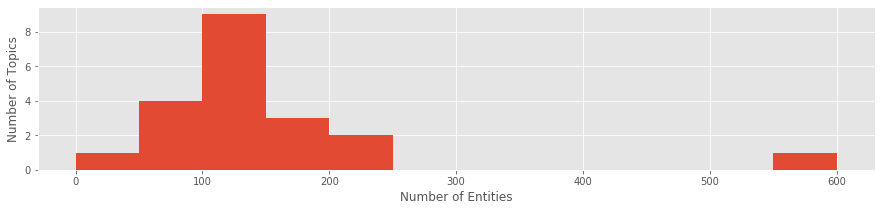

time: 235 ms


In [90]:
entities_per_topic = qlog[['topic', 'entities']] \
    .groupby('topic') \
    .apply(lambda df: len(list(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 50

entities_per_topic \
    .plot(kind='hist', bins=range(0, entities_per_topic.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Topics")
plt.show()

### Distribution of distinct entities per topic

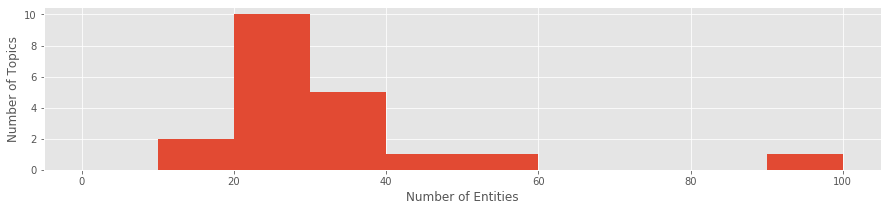

time: 221 ms


In [91]:
entities_per_topic = qlog[['topic', 'entities']] \
    .groupby('topic') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 10

entities_per_topic \
    .plot(kind='hist', bins=range(0, entities_per_topic.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Topics")
plt.show()

### Preparing entity subgraphs per topic

In [92]:
topic_count = qlog[['topic', 'query']] \
    .groupby('topic') \
    .count() \
    .rename(columns={'query': 'count'}) \
    .sort_values(by='count')

time: 9.47 ms


In [93]:
def entities_from_topic(topic):
    return set(flatten(
        qlog[qlog['topic'] == topic] \
            ['entities'].values.tolist()))

top_3_topic = topic_count.iloc[-3].name
display(top_3_topic)
entities_from_topic(top_3_topic)

'ohio ny information julius lyrics'

{'acid house kings',
 'cake',
 'cnn',
 'coachella',
 'do',
 'falmouth',
 'heart',
 'history',
 'kigs',
 'national',
 'north canton',
 'obituary',
 'ohio',
 'palos verdes',
 'pals',
 'pasadena',
 'reading',
 'red velvet',
 'spokane',
 'toledo',
 'treat',
 'verdes'}

time: 13.5 ms


In [94]:
@memory.cache
def get_entity_subgraphs_by_topic(topics):
    eg = {}
    for topic in progressbar.progressbar(topics):
        entities = entities_from_topic(topic)
        if entities:
            eg[topic] = entity_subgraph(entities, ignore_warn=True)
            eg[topic].vs['lpr'] = eg[topic].pagerank()    
    return eg

eg = get_entity_subgraphs_by_topic(qlog['topic'].unique())

time: 504 ms


### Visualizing entity subgraphs for topics

'christmas tree missouri liberty sc'

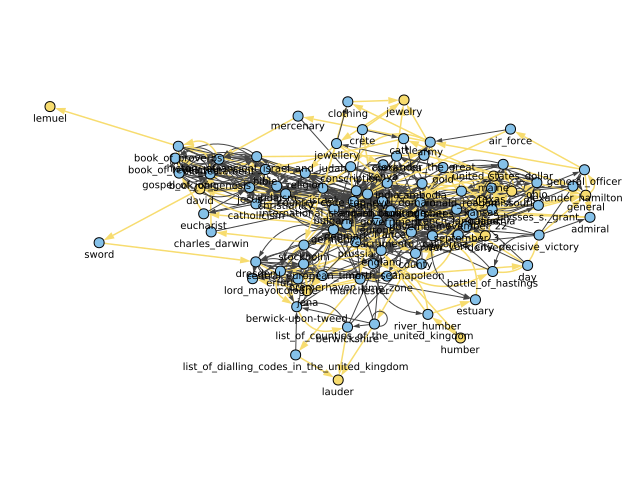

time: 121 ms


In [95]:
bottom_topic = topic_count.iloc[0].name
display(bottom_topic)
plot_subgraph(eg[bottom_topic], large=True)

### Distribution of global entity importance (PageRank) per topic

In [96]:
all_topics_pr = pd.concat(
    pd.DataFrame({ 'topic': topic, 'pr': eg[topic].vs['pr'], 'lpr': eg[topic].vs['lpr'] })
    for topic in eg.keys())

all_topics_pr

,topic,pr,lpr
0,lyrics carolina south pages book,2.450089e-04,0.004490
1,lyrics carolina south pages book,4.568679e-05,0.001651
2,lyrics carolina south pages book,1.468496e-04,0.003695
3,lyrics carolina south pages book,4.829241e-04,0.008167
...,...,...,...
87,christmas tree missouri liberty sc,2.512897e-06,0.003846
88,christmas tree missouri liberty sc,6.766102e-07,0.003670
89,christmas tree missouri liberty sc,7.375336e-07,0.002676
90,christmas tree missouri liberty sc,1.968814e-06,0.002910


time: 53.5 ms


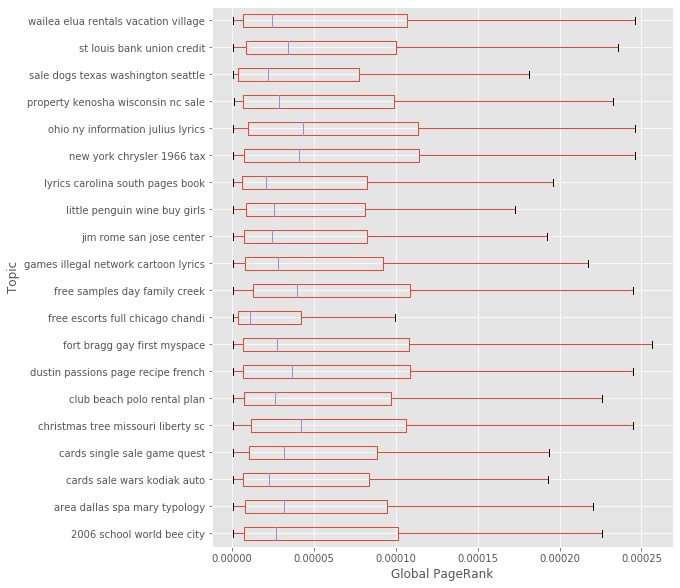

time: 661 ms


In [97]:
plt.rc('figure', figsize=[8, 10])

all_topics_pr[['topic', 'pr']] \
    .boxplot(by='topic', showfliers=False, vert=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Global PageRank")
plt.ylabel("Topic")
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

### Distribution of local entity importance (PageRank) per topic

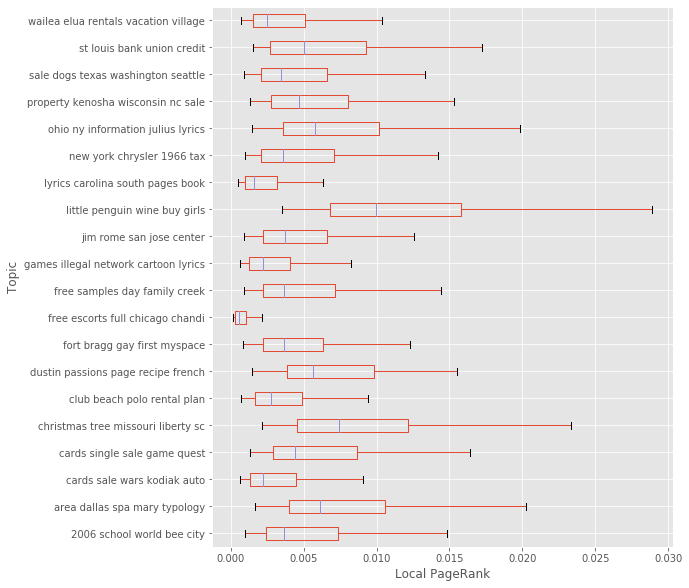

time: 576 ms


In [98]:
plt.rc('figure', figsize=[8, 10])

all_topics_pr[['topic', 'lpr']] \
    .boxplot(by='topic', showfliers=False, vert=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Local PageRank")
plt.ylabel("Topic")
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

### Distribution of topics per entity (top 25)

In [99]:
topics_per_entity = qlog[['topic', 'entities']]

null_idx = topics_per_entity.index[topics_per_entity['entities'].isnull()]

for idx in null_idx:
    topics_per_entity['entities'].at[idx] = []

topics_per_entity = pd.DataFrame([
    (row.topic, entity) for row in topics_per_entity.itertuples() for entity in row.entities],
    columns=['topic', 'entity'])

topics_per_entity = topics_per_entity[['entity', 'topic']] \
    .groupby('entity') \
    .nunique()[['topic']] \
    .sort_values(ascending=False, by="topic") \
    .head(25)

topics_per_entity

,topic
entity,
do,8
sale,7
aol,7
texas,6
...,...
las vegas,3
massachusetts,3
lansing,3
cancer,3


time: 296 ms


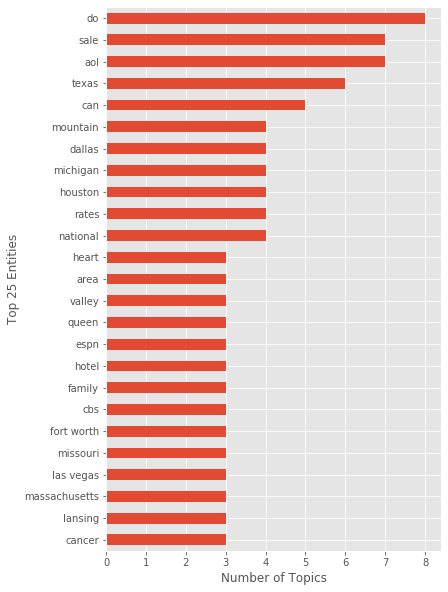

time: 344 ms


In [100]:
plt.rc('figure', figsize=[6, 10])

topics_per_entity['topic'] \
    .plot(kind='barh')
plt.xlabel('Number of Topics')
plt.ylabel('Top 25 Entities')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

# Entity-session-level analysis

- Distribution of entities per session
- Distribution of distinct entities per session
- Entity graphs for the top sessions with more entities:
  - Average distance between query entities
  - Global entity importance (PageRank)
  - Local entity importance (PageRank)
  - Global vs local PageRank
- Distribution of global entity importance (PageRank) per session
- Distribution of local entity importance (PageRank) per session

## Distribution of entities per session

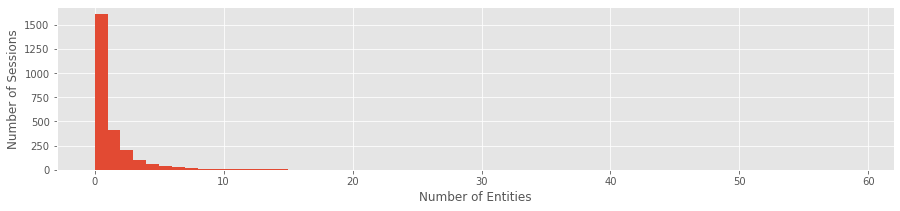

time: 453 ms


In [101]:
entities_per_session = qlog[['session_id', 'entities']] \
    .groupby('session_id') \
    .apply(lambda df: len(list(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 1

entities_per_session \
    .plot(kind='hist', bins=range(0, entities_per_session.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Sessions")
plt.show()

## Distribution of distinct entities per session

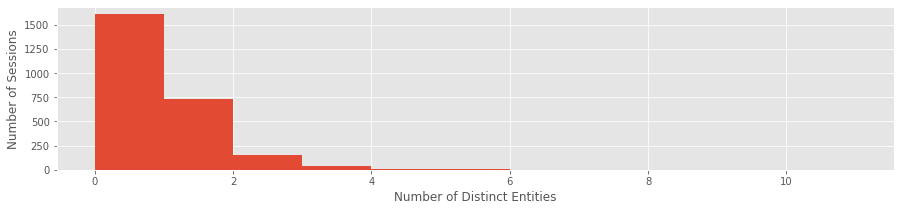

time: 401 ms


In [102]:
distinct_entities_per_session = qlog[['session_id', 'entities']] \
    .groupby('session_id') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 1

distinct_entities_per_session \
    .plot(kind='hist', bins=range(0, distinct_entities_per_session.max() + bin_width, bin_width))
plt.xlabel("Number of Distinct Entities")
plt.ylabel("Number of Sessions")
plt.show()

## Identifying the entities for the top sessions with distinct entities

In [103]:
top_sessions = distinct_entities_per_session \
    .head()
top_sessions

session_id
2091    11
1767     6
425      5
282      5
4        5
dtype: int64

time: 10.2 ms


## Preparing entity subgraphs per session

In [104]:
def entities_from_session(session_id):
    return set(flatten(
        qlog[qlog['session_id'] == session_id] \
            ['entities'].values.tolist()))

entities_from_session(2091)

{'burren',
 'espn',
 'family',
 'frank sinatra',
 'green day',
 'jay z',
 'myspace',
 'nas',
 'toto',
 'toto cutugno',
 'yes'}

time: 11.4 ms


In [105]:
@memory.cache
def get_entity_subgraphs_by_session_id(session_ids):
    eg = {}
    for session_id in progressbar.progressbar(session_ids):
        entities = entities_from_session(session_id)
        if entities:
            eg[session_id] = entity_subgraph(entities, ignore_warn=True)
            eg[session_id].vs['lpr'] = eg[session_id].pagerank()    
    return eg

eg = get_entity_subgraphs_by_session_id(qlog['session_id'].unique())

time: 164 ms


## Visualizing entity subgraphs for sessions

Below we visualize the entity graphs for two top-5 sessions (2091 and 4) and a smaller session (2080).

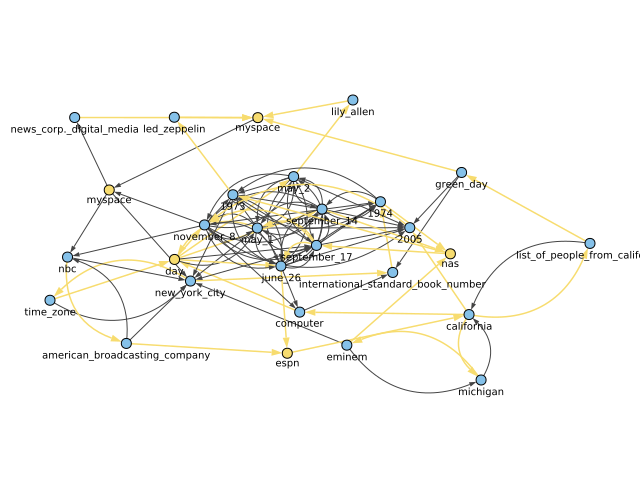

time: 72.9 ms


In [106]:
plot_subgraph(eg[2091], large=True)

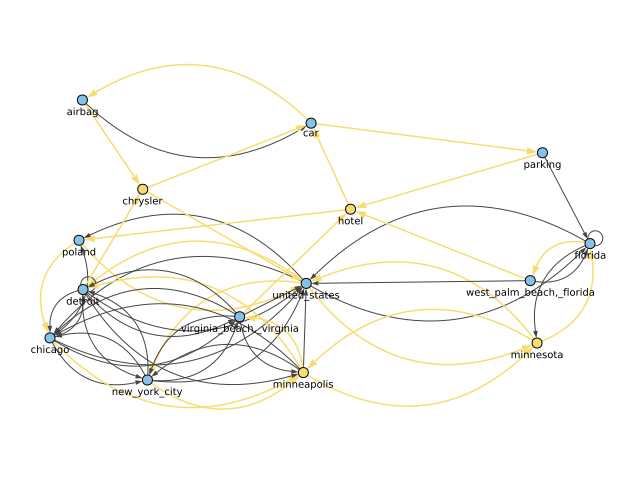

time: 56.4 ms


In [107]:
plot_subgraph(eg[4], large=True)

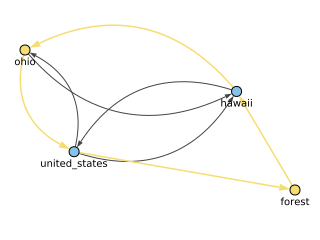

time: 14.1 ms


In [108]:
plot_subgraph(eg[2080])

## Distance between query entities

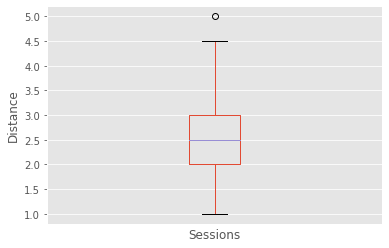

time: 240 ms


In [109]:
s_avg_dists = []
for session_id, sg in eg.items():
    s_dists = sg.shortest_paths(source=sg.vs.select(is_source=True), target=sg.vs.select(is_source=True))
    s_dists = list(filter(lambda x: x > 0, flatten(s_dists)))
    
    if len(s_dists) < 1 or np.inf in s_dists:
        continue
    
    s_avg_dist = np.mean(s_dists)
    s_avg_dists.append(s_avg_dist)

s_avg_dists = pd.DataFrame(s_avg_dists, columns=['avg_dist'])

plt.rc('figure', figsize=[6, 4])

s_avg_dists \
    .boxplot()

plt.xticks([])
plt.xlabel("Sessions")
plt.ylabel("Distance")

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Global entity importance (PageRank)

In [110]:
session_ids = []
pr = []
lpr = []

for session_id in top_sessions.index:
    if session_id in eg:
        for v in eg[session_id].vs:
            session_ids.append(session_id)
            pr.append(v['pr'])
            lpr.append(v['lpr'])

session_pr = pd.DataFrame({ 'session_id': session_ids, 'page_rank': pr, 'local_page_rank': lpr }) \
    .set_index('session_id')

session_pr.index = pd.Categorical(session_pr.index, categories=top_sessions.index)
session_pr.index.name = 'session_id'

time: 10.6 ms


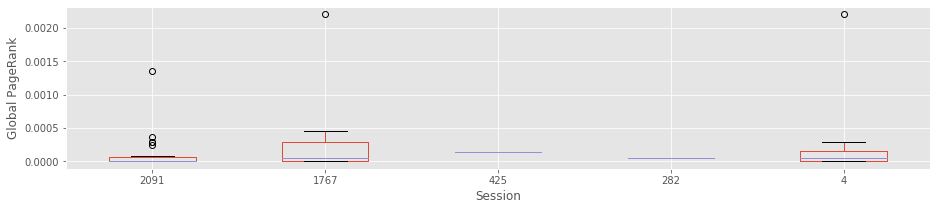

time: 241 ms


In [111]:
session_pr[['page_rank']] \
    .boxplot(by='session_id')

plt.xlabel("Session")
plt.ylabel("Global PageRank")
plt.title(None)
plt.suptitle(None)
plt.show()

## Local entity importance (PageRank)

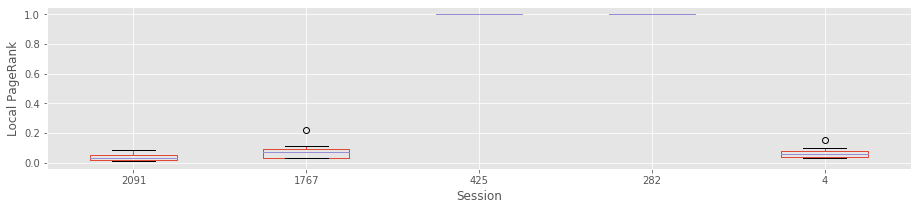

time: 238 ms


In [112]:
session_pr[['local_page_rank']] \
    .boxplot(by='session_id')

plt.xlabel("Session")
plt.ylabel("Local PageRank")
plt.title(None)
plt.suptitle(None)
plt.show()

## Global vs local PageRank

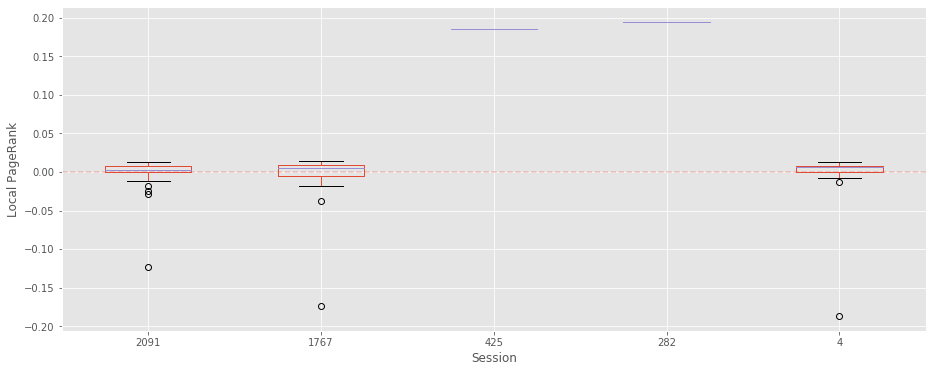

time: 591 ms


In [113]:
session_pr['norm_page_rank'] = session_pr['page_rank'] / session_pr['page_rank'].sum()
session_pr['norm_local_page_rank'] = session_pr['local_page_rank'] / session_pr['local_page_rank'].sum()
session_pr['norm_page_rank_diff'] = session_pr['norm_local_page_rank'] - session_pr['norm_page_rank']

plt.rc('figure', figsize=[DEFAULT_FIGSIZE[0], 6])

session_pr[['norm_page_rank_diff']] \
    .boxplot(by='session_id') \
    .axhline(y=0, alpha=0.3, linestyle='--')

plt.xlabel("Session")
plt.ylabel("Local PageRank")
plt.title(None)
plt.suptitle(None)
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

**Q:** Why does session 1224 show a higher absolute difference than the remaining sessions?

**H1:** Is it because of the number of queries?

In [114]:
session_queries = qlog[qlog['entities'].map(lambda e: len(e) if e else 0) > 0][['session_id', 'query']] \
    .set_index('session_id') \
    .loc[top_sessions.index]

session_queries.index = pd.Categorical(session_queries.index, categories=top_sessions.index)
session_queries.index.name = 'session_id'

session_queries \
    .groupby(['session_id']) \
    .nunique() \
    .reset_index()

,session_id,query
0,2091,10
1,1767,6
2,425,7
3,282,4
4,4,4


time: 25.4 ms


No. The behavior is simular for sessions 2091 and 1224 for the number of queries, but the highest change in PageRank was for session 1224.

**H2:** Is it because of the number of entities?

In [115]:
top_sessions \
    .reset_index() \
    .rename({ 0: 'entity' }, axis=1)

,session_id,entity
0,2091,11
1,1767,6
2,425,5
3,282,5
4,4,5


time: 14.4 ms


No. The behavior was similar for sessions 2091 and 1224 in number of entities, but the highest change in PageRank was for session 1224.

**H3:** Is is because of the semantics of the queries?

In [116]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    query_count_per_session = session_queries \
        .groupby(['session_id', 'query']) \
        .size() \
        .reset_index() \
        .rename({ 0: 'count'}, axis=1) \
        .sort_values(by=['session_id', 'count'], ascending=[True, False])
    
    query_count_per_session['query_length'] = query_count_per_session['query'].map(len)
    
    display(query_count_per_session)

,session_id,query,count,query_length
6,2091,myspace icons,2,13
9,2091,yes,2,3
0,2091,armin van burren,1,16
1,2091,espn,1,4
2,2091,family guy,1,10
3,2091,frank sinatra,1,13
4,2091,green day,1,9
5,2091,jay z,1,5
7,2091,nas,1,3
8,2091,toto cutugno,1,12


time: 30.2 ms


Although the sample is too small, there seems to be a relation between query length and the change in PageRank. We investigate further, using the entity subgraphs for all sessions instead of the top sessions (i.e., with a higher number of distinct entities).

In [117]:
all_session_pr = pd.concat(
    pd.DataFrame({ 'session_id': session_id, 'pr': eg[session_id].vs['pr'], 'lpr': eg[session_id].vs['lpr'] })
    for session_id in eg.keys())

all_session_pr = all_session_pr \
    .set_index('session_id')

all_session_pr['pr'] = all_session_pr['pr'] / all_session_pr['pr'].sum()
all_session_pr['lpr'] = all_session_pr['lpr'] / all_session_pr['lpr'].sum()

all_session_pr = all_session_pr \
    .groupby('session_id') \
    .mean()

all_session_pr['pr_diff'] = all_session_pr['lpr'] - all_session_pr['pr']

all_session_pr = all_session_pr.merge(
    qlog[qlog['entities'].map(lambda e: len(e) if e else 0) > 0][['session_id', 'length']] \
        .groupby('session_id') \
        .mean(), on='session_id')

all_session_pr['pr_diff'].corr(all_session_pr['length'], method='spearman')

-0.1427512632478527

time: 989 ms


Based on the mean PageRanks and query lengths per session, there is no correlation with the change in PageRanks. Since the difference is so small, this is probably a random difference that we can disregard.

## Distribution of global entity importance (PageRank) per session

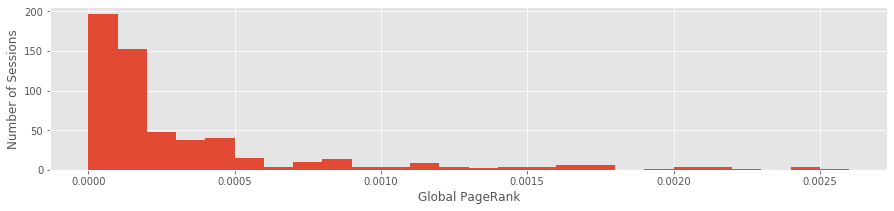

time: 234 ms


In [118]:
d_max = all_session_pr['pr'].max()
bin_width= 0.0001

all_session_pr['pr'] \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width))
plt.xlabel('Global PageRank')
plt.ylabel('Number of Sessions')
plt.show()

## Distribution of local entity importance (PageRank) per session

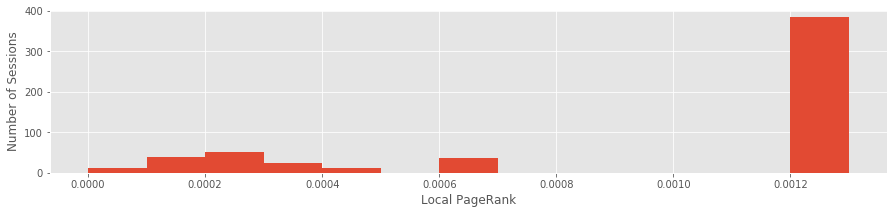

time: 253 ms


In [119]:
d_max = all_session_pr['lpr'].max()
bin_width= 0.0001

all_session_pr['lpr'] \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width))
plt.xlabel('Local PageRank')
plt.ylabel('Number of Sessions')
plt.show()

# Entity-term-level analysis

- Distribution of entities per query length (in number of terms)
- Distribution of terms per entity

## Distribution of entities per query length (in number of terms)

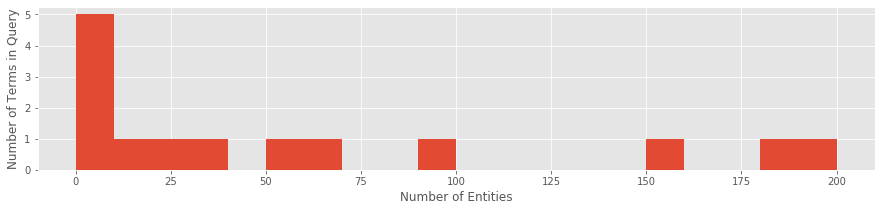

time: 304 ms


In [120]:
entities_per_query_num_terms = qlog[['num_terms', 'entities']] \
    .groupby('num_terms') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 10

entities_per_query_num_terms \
    .plot(kind='hist', bins=range(0, entities_per_query_num_terms.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Terms in Query")
plt.show()

## Distribution of terms per entity (top 25)

In [121]:
unique_entities = np.unique([
    entity for entities in qlog['entities'] if entities
    for entity in entities])

terms_per_entity = pd.DataFrame({'entity': unique_entities})
terms_per_entity['entity_num_terms'] = terms_per_entity['entity'].map(lambda entity: len(entity.split(' ')))

terms_per_entity = terms_per_entity \
    .sort_values(by='entity_num_terms', ascending=False)

terms_per_entity

,entity,entity_num_terms
156,food and drug administration,4
0,a static lullaby,3
330,national cancer institute,3
467,the juliana theory,3
...,...,...
264,lansing,1
263,lamp,1
262,lamay,1
511,yes,1


time: 19.9 ms


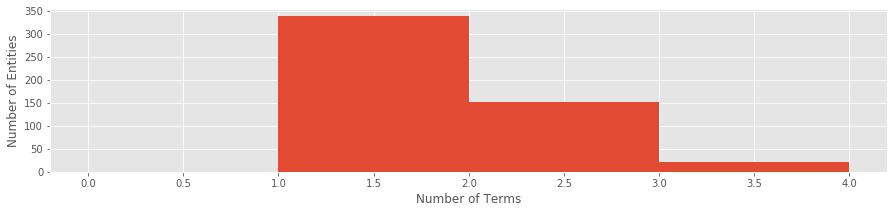

time: 289 ms


In [122]:
d_max = terms_per_entity['entity_num_terms'].max()
bin_width = 1

terms_per_entity['entity_num_terms'] \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width))
plt.xlabel('Number of Terms')
plt.ylabel('Number of Entities')
plt.show()

# Entity-entity-level analysis

- Entity co-occurrence graph
  - Entity co-occurrence graph vs Simple Wikipedia link graph
    - Indegree correlation
    - PageRank correlation
    - Closeness centrality correlation
    - Betweenness centrality correlation

## Entity co-occurrence graph

### Building and characterizing the entity co-occurrence graph

In [123]:
@memory.cache
def build_entity_cooccurrence_graph():
    g = igraph.Graph()
    
    graph = {}
    
    for t in qlog.itertuples():
        if t.entities is None:
            continue
        
        for source in t.entities:
            if not source in graph:
                graph[source] = {}
            
            for target in t.entities:
                if source != target:
                    if not target in graph[source]:
                        graph[source][target] = 1
                    else:
                        graph[source][target] += 1

    g.add_vertices(iter(graph.keys()))
    edges = [(source, target) for source in graph.keys() for target in graph[source].keys()]
    edges = [edge for edge in edges if edge[0] > edge[1]]
    g.add_edges(edges)
    
    return g

cg = build_entity_cooccurrence_graph()

time: 46.9 ms


In [124]:
cg_stats = compute_stats(cg); cg_stats

vertices          707.000000
edges             257.000000
avg_clust_coef      0.403587
density             0.001030
num_cc            501.000000
avg_cc_size         1.411178
stdev_cc_size       2.554514
dtype: float64

time: 206 ms


In [125]:
cg.vs['in'] = cg.indegree()
cg.vs['pr'] = cg.pagerank()
cg.vs['cc'] = cg.closeness()
cg.vs['bc'] = cg.betweenness()
cg.vs['label'] = cg.vs['name']

time: 7.96 ms


### Visualizing the entity co-occurrence graph

Below we plot the components with more than three nodes.

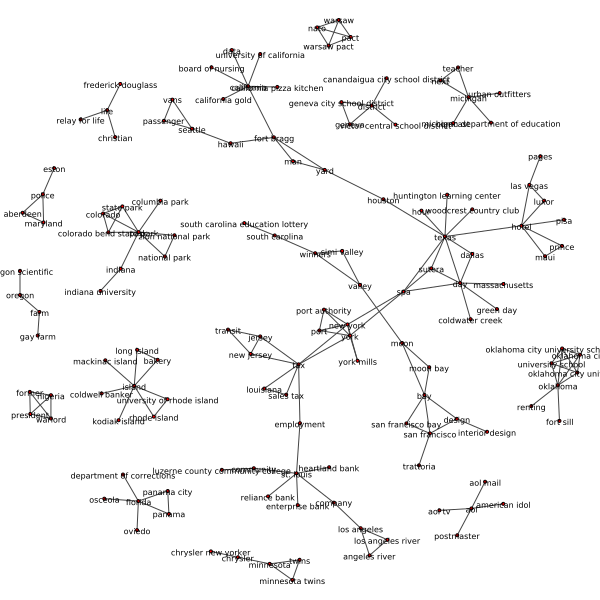

time: 166 ms


In [126]:
cg_components = [cg_component for cg_component in cg.components() if len(cg_component) > 3]
igraph.plot(cg.subgraph(flatten(cg_components)), vertex_size=3, vertex_label_size=8)

## Entity co-occurrence graph vs Simple Wikipedia link graph

First, we prepare the Simple Wikipedia subgraph containing only the entity nodes in the co-occurrence graph.

In [127]:
sg = g.subgraph(g.vs.select(label_in=cg.vs['label']))

time: 8.48 s


In [128]:
sg.vs['in'] = sg.indegree()
sg.vs['pr'] = sg.pagerank()
sg.vs['cc'] = sg.closeness()
sg.vs['bc'] = sg.betweenness()

time: 15.1 ms


In [129]:
sg_stats = compute_stats(sg); sg_stats

vertices           358.000000
edges             1552.000000
avg_clust_coef       0.700346
density              0.012143
num_cc             241.000000
avg_cc_size          1.485477
stdev_cc_size        6.629558
dtype: float64

time: 45.3 ms


### Indegree correlation

In [130]:
sg_in = pd.DataFrame({ 'entity': sg.vs['label'], 'in_sg': sg.vs['in'] })
cg_in = pd.DataFrame({ 'entity': cg.vs['label'], 'in_cg': cg.vs['in'] })
df_in = sg_in.merge(cg_in)
df_in['in_sg'].corr(df_in['in_cg'])

0.2444441834565536

time: 19.9 ms


### PageRank correlation

In [131]:
sg_pr = pd.DataFrame({ 'entity': sg.vs['label'], 'pr_sg': sg.vs['pr'] })
cg_pr = pd.DataFrame({ 'entity': cg.vs['label'], 'pr_cg': cg.vs['pr'] })
df_pr = sg_pr.merge(cg_pr)
df_pr['pr_sg'].corr(df_pr['pr_cg'])

0.20622073644796002

time: 20.8 ms


### Closeness centrality correlation

In [132]:
sg_cc = pd.DataFrame({ 'entity': sg.vs['label'], 'cc_sg': sg.vs['cc'] })
cg_cc = pd.DataFrame({ 'entity': cg.vs['label'], 'cc_cg': cg.vs['cc'] })
df_cc = sg_cc.merge(cg_cc)
df_cc['cc_sg'].corr(df_cc['cc_cg'])

0.1067526533029727

time: 16.6 ms


### Betweenness centrality correlation

In [133]:
sg_bc = pd.DataFrame({ 'entity': sg.vs['label'], 'bc_sg': sg.vs['bc'] })
cg_bc = pd.DataFrame({ 'entity': cg.vs['label'], 'bc_cg': cg.vs['bc'] })
df_bc = sg_bc.merge(cg_bc)
df_bc['bc_sg'].corr(df_bc['bc_cg'])

0.07713627173530872

time: 14.1 ms


# Entity-session-query-level analysis

- Distribution of average number of entities per session over time
- Distribution of average entity importance (PageRank) per session over time

### Distribution of average number of entities per session over time

In [134]:
entities_per_session_over_time = pd.DataFrame(qlog[['query', 'session_id', 'entities', 'timestamp']])

entities_per_session_over_time['entities'] = \
    entities_per_session_over_time['entities'].map(lambda e: len(e) if e else 0)

entities_per_session_over_time['delta_time'] = entities_per_session_over_time[['session_id', 'timestamp']] \
    .groupby('session_id') \
    .transform(lambda x: x - x.min())

entities_per_session_over_time = entities_per_session_over_time \
    .groupby(['session_id', 'delta_time']) \
    .sum() \
    .reset_index()[['delta_time', 'entities']] \
    .groupby('delta_time') \
    .mean() \
    .rolling(window=30) \
    .mean()

entities_per_session_over_time.index = pd.to_datetime(
    entities_per_session_over_time.index.map(lambda t: int(t.total_seconds())),
    unit='s')

entities_per_session_over_time

,entities
delta_time,
1970-01-01 00:00:00,NaN
1970-01-01 00:00:01,NaN
1970-01-01 00:00:02,NaN
1970-01-01 00:00:03,NaN
...,...
1970-01-01 02:37:32,0.166667
1970-01-01 02:39:20,0.166667
1970-01-01 03:04:40,0.166667
1970-01-01 03:25:45,0.133333


time: 4.86 s


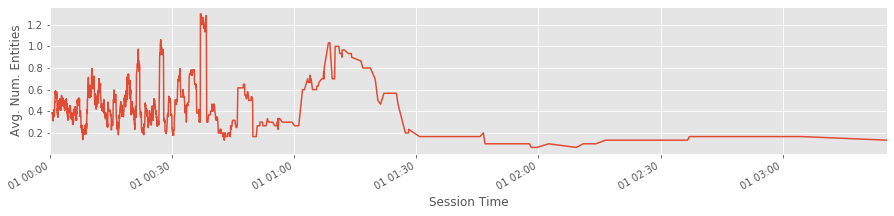

time: 315 ms


In [135]:
entities_per_session_over_time \
    .plot(kind='line', legend=False)
plt.xlabel('Session Time')
plt.ylabel('Avg. Num. Entities')
plt.show()

### Distribution of average entity importance (PageRank) per session over time

In [136]:
@memory.cache
def compute_entity_importance_per_session_over_time():
    entity_importance_per_session_over_time = pd.DataFrame(qlog[['query', 'session_id', 'entities', 'timestamp']])

    def entities_to_pagerank(entities):
        pr_v = []
        for entity in entities:
            try:
                pr_v.append(g.vs.find(label=entity)['pr'])
            except ValueError:
                pr_v.append(0)
        return pr_v

    entity_importance_per_session_over_time['avg_pr'] = \
        entity_importance_per_session_over_time['entities'] \
            .map(lambda e: np.mean(entities_to_pagerank(e)) if e else 0)

    entity_importance_per_session_over_time['delta_time'] = \
        entity_importance_per_session_over_time[['session_id', 'timestamp']] \
            .groupby('session_id') \
            .transform(lambda x: x - x.min())

    entity_importance_per_session_over_time = entity_importance_per_session_over_time \
        .groupby(['session_id', 'delta_time']) \
        .sum() \
        .reset_index()[['delta_time', 'avg_pr']] \
        .groupby('delta_time') \
        .mean() \
        .rolling(window=30) \
        .mean()

    entity_importance_per_session_over_time.index = pd.to_datetime(
        entity_importance_per_session_over_time.index.map(lambda t: int(t.total_seconds())),
        unit='s')

    return entity_importance_per_session_over_time

entity_importance_per_session_over_time = compute_entity_importance_per_session_over_time()
entity_importance_per_session_over_time

,avg_pr
delta_time,
1970-01-01 00:00:00,NaN
1970-01-01 00:00:01,NaN
1970-01-01 00:00:02,NaN
1970-01-01 00:00:03,NaN
...,...
1970-01-01 02:37:32,0.000003
1970-01-01 02:39:20,0.000003
1970-01-01 03:04:40,0.000003
1970-01-01 03:25:45,0.000003


time: 48.9 ms


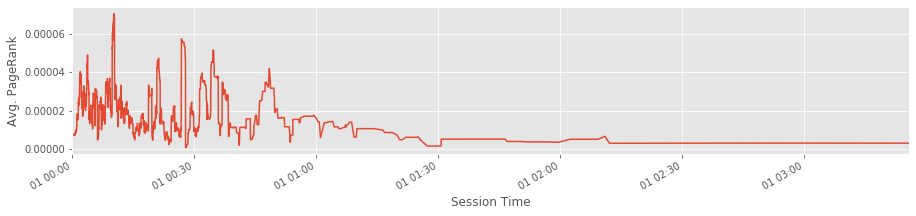

time: 214 ms


In [137]:
entity_importance_per_session_over_time \
    .plot(kind='line', legend=False)
plt.xlabel('Session Time')
plt.ylabel('Avg. PageRank')
plt.show()